# CT650 Group Assignment 1
## New_York_cars.csv
## by :
- ### Mostafa Mohamed Mohamed Imam
- ### Mervat Khaled Emam


<br>

#### Data used: https://www.kaggle.com/datasets/ahmettalhabektas/new-york-cars-big-data-2023

#### Docker Image used: https://hub.docker.com/r/jupyter/all-spark-notebook/

<br>

### Questions :
- #### Can we predict the sale price of a car based on its characteristics (e.g., make, model, year, mileage) and listing details using Linear Regression? 

- #### How do different car brands and models vary in terms of their resale value over time? Analyze trends to provide insights into the best-value purchases. 

In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, count, when, isnan, lit, countDistinct
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [3]:
spark = SparkSession.builder \
    .appName("CT650_GA1_NY_Cars") \
    .getOrCreate()

In [4]:
spark

In [5]:
NY_cars = spark.read.csv('New_York_cars.csv', header=True, inferSchema=True)

In [6]:
NY_cars.printSchema()

root
 |-- new&used: string (nullable = true)
 |-- name: string (nullable = true)
 |-- money: integer (nullable = true)
 |-- Exterior color: string (nullable = true)
 |-- Interior color: string (nullable = true)
 |-- Drivetrain: string (nullable = true)
 |-- MPG: string (nullable = true)
 |-- Fuel type: string (nullable = true)
 |-- Transmission: string (nullable = true)
 |-- Engine: string (nullable = true)
 |-- Mileage: integer (nullable = true)
 |-- Convenience: string (nullable = true)
 |-- Entertainment: string (nullable = true)
 |-- Exterior: string (nullable = true)
 |-- Safety: string (nullable = true)
 |-- Seating: string (nullable = true)
 |-- Accidents or damage: string (nullable = true)
 |-- Clean title: string (nullable = true)
 |-- 1-owner vehicle: string (nullable = true)
 |-- Personal use only: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Model: string (nullable = true)
 |-- currency: string (nullable = true)



In [7]:
NY_cars.select('Model').show(1000)

+--------------------+
|               Model|
+--------------------+
|        Integra Base|
|          Mdx A-Spec|
|Integra A-Spec Te...|
|          Tlx A-Spec|
|          Tlx A-Spec|
|      Mdx Technology|
|          Mdx A-Spec|
|Integra A-Spec Te...|
|          Rdx A-Spec|
|            Mdx Base|
|          Tlx Type S|
|          Tlx A-Spec|
|  Rdx A-Spec Advance|
|Rdx A-Spec Advanc...|
|Integra A-Spec Te...|
|Mdx Type S W/Adva...|
|Integra A-Spec Te...|
|Rdx A-Spec Advanc...|
|          Tlx A-Spec|
|Integra W/A-Spec ...|
|          Tlx A-Spec|
|          Tlx A-Spec|
|          Tlx A-Spec|
|Integra W/A-Spec ...|
|          Rdx A-Spec|
|          Tlx A-Spec|
|Integra W/A-Spec ...|
|      Mdx Technology|
|Integra A-Spec Te...|
|Rdx A-Spec Advanc...|
|      Mdx Technology|
|         Mdx Advance|
|            Rdx Base|
|         Tlx Advance|
|      Tlx Technology|
|      Mdx Technology|
|      Mdx Technology|
|  Rdx A-Spec Advance|
|Rdx Technology Pa...|
|Tlx Type S W/Perf...|
|          

### New_york_Cars 

We'll start by working on the new york cars dataframe as it has more info about the cars and will likely have more data preprocessing to deal with, and it will also give as better insights about the cars and car brands in multiple areas.


Here is a brief overview of the columns:

- **`new&used`**: The condition of the car, indicating whether it is new or used.
- **`name`**: The full name or designation of the car model.
- **`money`**: The listed price of the car.
- **`Exterior color`**: The color of the car's exterior.
- **`Interior color`**: The color scheme of the car's interior.
- **`Drivetrain`**: The type of drivetrain system in the car, such as FWD (front-wheel drive) or AWD (all-wheel drive).
- **`MPG`**: The fuel efficiency rating, measured in miles per gallon.
- **`Fuel type`**: The kind of fuel the car uses, like gasoline or diesel.
- **`Transmission`**: The car's transmission type, such as automatic or manual.
- **`Engine`**: Specifications of the car's engine, including type and size.
- **`Mileage`**: The total distance the car has traveled.
- **`Convenience`**: Features that add convenience for the driver and passengers.
- **`Entertainment`**: Multimedia and entertainment options available in the car.
- **`Exterior`**: Features related to the car's external appearance and functionality.
- **`Safety`**: Safety features and technologies included in the car.
- **`Seating`**: Details about the seating arrangements and materials.
- **`Accidents or damage`**: Information on any past accidents or damage the car may have sustained.
- **`Clean title`**: Indicates whether the car has a clean legal history without any major issues.
- **`1-owner vehicle`**: Specifies if the car has had only one previous owner.
- **`Personal use only`**: Denotes whether the car was exclusively used for personal purposes.
- **`brand`**: The make or brand of the car.
- **`Year`**: The year the car was manufactured.
- **`Model`**: The specific model of the car.
- **`currency`**: The currency in which the car's price is denoted.


We'll start the work on the dataframe by checking for null values in all the columns and present their percentages in each column in a descending order.

In [8]:
def analyze_dataframe(df: DataFrame):
    """
    Analyzes a PySpark DataFrame to calculate and print the percentage of null values,
    the number of unique values, and the actual unique values for each column if there
    are fewer than 30 unique values.

    Parameters:
    df (DataFrame): The PySpark DataFrame to be analyzed.

    Returns:
    None: This function prints the analysis results to the console and does not return any value.
    
    Examples:
    >>> analyze_dataframe(spark_df)
    Column: owner vehicle
    Null Value Percentage: 5.00%
    Unique Values: ['Yes', 'No']
    ----------------------------------------
    """
    
    # Calculate the total number of rows for percentage calculation
    total_rows = df.count()
    
    # Define a function to calculate the null percentage
    def null_percentage(column_name):
        """
        Calculates the percentage of null or NaN values in a given column.

        Parameters:
        column_name (str): The name of the column to calculate the null percentage for.

        Returns:
        Column: A PySpark Column object representing the null percentage calculation.
        """
        return (count(when(col(column_name).isNull() | isnan(column_name), column_name)) / lit(total_rows)) * 100
    
    # Define a function to collect unique values if less than 30
    def unique_values(column_name):
        """
        Collects and returns the unique values of a given column if there are fewer than 30 unique values.
        If there are 30 or more unique values, it returns a string indicating this.

        Parameters:
        column_name (str): The name of the column to collect unique values from.

        Returns:
        list or str: A list of unique values if fewer than 30, otherwise a string message.
        """
        unique_vals = df.select(column_name).distinct().collect()
        if len(unique_vals) < 30:
            return [row[column_name] for row in unique_vals]
        else:
            return f"More than 30 unique values for {column_name}"
    
    # Analyze each column
    for column in df.columns:
        null_percentage_col = df.agg(null_percentage(column).alias('null_percentage')).collect()[0]['null_percentage']
        unique_vals_col = unique_values(column)
        
        print(f"Column: {column}")
        print(f"Null Value Percentage: {null_percentage_col:.2f}%")
        print(f"Unique Values: {unique_vals_col}")
        print("-" * 40)


In [9]:
# Analyze each column and present unique values
analyze_dataframe(NY_cars)

Column: new&used
Null Value Percentage: 0.00%
Unique Values: ['Bmw Certified', 'Used', 'Acura Certified', 'New', 'Buick Certified', 'Cadillac Certified', 'Chevrolet Certified', 'Dodge Certified', 'Chrysler Certified', 'Ford Certified', 'Honda Certified', 'Gmc Certified', 'Jeep Certified', 'Infiniti Certified', 'Kia Certified', 'Mercedes-Benz Certified', 'Nissan Certified', 'Mitsubishi Certified', 'Ram Certified', 'Porsche Certified', 'Subaru Certified', 'Toyota Certified', 'Volkswagen Certified', 'Volvo Certified']
----------------------------------------
Column: name
Null Value Percentage: 0.00%
Unique Values: More than 30 unique values for name
----------------------------------------
Column: money
Null Value Percentage: 0.00%
Unique Values: More than 30 unique values for money
----------------------------------------
Column: Exterior color
Null Value Percentage: 1.08%
Unique Values: More than 30 unique values for Exterior color
----------------------------------------
Column: Interi

In [10]:
# Calculate null value percentages for all columns
null_percentage_dict = {col_name: (NY_cars.filter(col(col_name).isNull())
                                   .agg((count("*") / NY_cars.count()).alias("null_percentage"))
                                   .first()["null_percentage"])
                        for col_name in NY_cars.columns}


# Sort the the columns in the dictionary by decreasing order of null percentages
sorted_null_percentage_dict_desc = dict(sorted(null_percentage_dict.items(), key=lambda item: item[1], reverse=True))

print(f"Null percentage for columns sorted by values (desc): {sorted_null_percentage_dict_desc}")

Null percentage for columns sorted by values (desc): {'Clean title': 0.8965753034360933, 'Seating': 0.3285315402587042, '1-owner vehicle': 0.3008661462191578, 'Personal use only': 0.2995897202119779, 'Accidents or damage': 0.29958402188158867, 'MPG': 0.18282523220696337, 'Convenience': 0.17056812353980283, 'Exterior': 0.09634737022052539, 'Interior color': 0.0848823294774631, 'Entertainment': 0.05075502877656846, 'Safety': 0.011066157615818565, 'Exterior color': 0.010781241096358767, 'Fuel type': 0.007652857712690182, 'Transmission': 0.004353524417345718, 'Drivetrain': 0.003168271696392957, 'Engine': 0.0018918456892130606, 'Mileage': 0.0002678215282922104, 'new&used': 0.0, 'name': 0.0, 'money': 0.0, 'brand': 0.0, 'Year': 0.0, 'Model': 0.0, 'currency': 0.0}


In [11]:
NY_cars.show(10)

+--------+--------------------+-----+--------------------+--------------+----------+------+---------+------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------+---------------+-----------------+-----+----+--------------------+--------+
|new&used|                name|money|      Exterior color|Interior color|Drivetrain|   MPG|Fuel type|      Transmission|              Engine|Mileage|         Convenience|       Entertainment|            Exterior|              Safety|             Seating|Accidents or damage|Clean title|1-owner vehicle|Personal use only|brand|Year|               Model|currency|
+--------+--------------------+-----+--------------------+--------------+----------+------+---------+------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--

Now we're going to convert the spark dataframe into a pandas dataframe just to use `missingo` on it to get an idea about the missing data patterns then we are going to remove it from memory afterwards and switch to using the `pandas_api()` which is the newer stable version of the `to_pandas_on_spark()` which allows us to convert a spark dataframe into a pandas dataframe that still maintains some of spark's distributed computing techniques.

In [12]:
NY_cars_PDS = NY_cars.toPandas()

In [13]:
NY_cars_PDS.head(20)

,new&used,name,money,Exterior color,Interior color,Drivetrain,MPG,Fuel type,Transmission,Engine,...,Safety,Seating,Accidents or damage,Clean title,1-owner vehicle,Personal use only,brand,Year,Model,currency
0,New,2023 Acura Integra Base,33095,Liquid Carbon Metallic,Ebony,Fwd,30–37,Gasoline,Automatic Cvt,1.5L I4 16V Gdi Dohc Turbo,...,Automatic Emergency BrakingBackup CameraBrak...,Leather Seats,None,None,None,None,Acura,2023,Integra Base,$
1,New,2023 Acura Mdx A-Spec,61745,Majestic Black Pearl,Ebony,Awd,19–25,Gasoline,10-Speed Automatic,3.5L V6 24V Gdi Sohc,...,Backup CameraBrake AssistLane Departure Warn...,Leather SeatsMemory SeatThird Row Seating,None,None,None,None,Acura,2023,Mdx A-Spec,$
2,New,2023 Acura Integra A-Spec Technology,38095,Majestic Black Pearl,Ebony,Fwd,26–36,Gasoline,6-Speed Manual,1.5L I4 16V Gdi Dohc Turbo,...,Backup CameraBrake AssistLane Departure Warn...,Leather SeatsMemory Seat,None,None,None,None,Acura,2023,Integra A-Spec Technology,$
3,New,2023 Acura Tlx A-Spec,47995,Majestic Black Pearl,Ebony,Fwd,22–30,Gasoline,10-Speed Automatic,2.0L I4 16V Gdi Dohc Turbo,...,Backup CameraBrake AssistLane Departure Warn...,Leather SeatsMemory Seat,None,None,None,None,Acura,2023,Tlx A-Spec,$
4,New,2023 Acura Tlx A-Spec,47995,Platinum White Pearl,Red,Fwd,22–30,Gasoline,10-Speed Automatic,2.0L I4 16V Gdi Dohc Turbo,...,Backup CameraBrake AssistLane Departure Warn...,Leather SeatsMemory Seat,None,None,None,None,Acura,2023,Tlx A-Spec,$
5,New,2023 Acura Mdx Technology,58245,Majestic Black Pearl,Ebony,Awd,19–25,Gasoline,10-Speed Automatic,3.5L V6 24V Gdi Sohc,...,Backup CameraBrake AssistLane Departure Warn...,Leather SeatsMemory SeatThird Row Seating,None,None,None,None,Acura,2023,Mdx Technology,$
6,New,2023 Acura Mdx A-Spec,61645,Platinum White Pearl,Red,Awd,19–25,Gasoline,10-Speed Automatic,3.5L V6 24V Gdi Sohc,...,Backup CameraBrake AssistLane Departure Warn...,Leather SeatsMemory SeatThird Row Seating,None,None,None,None,Acura,2023,Mdx A-Spec,$
7,New,2023 Acura Integra A-Spec Technology,37395,Apex Blue Pearl,Orchid,Fwd,26–36,Gasoline,6-Speed Manual,1.5L I4 16V Gdi Dohc Turbo,...,Backup CameraBlind Spot MonitorBrake AssistS...,Leather SeatsMemory Seat,None,None,None,None,Acura,2023,Integra A-Spec Technology,$
8,New,2023 Acura Rdx A-Spec,48395,Lunar Silver Metallic,Ebony,Fwd,22–27,Gasoline,10-Speed Automatic,2.0L I4 16V Gdi Dohc Turbo,...,Backup CameraBrake AssistLane Departure Warn...,Leather SeatsMemory Seat,None,None,None,None,Acura,2023,Rdx A-Spec,$
9,New,2023 Acura Mdx Base,53545,Platinum White Pearl,Parchment,Awd,19–25,Gasoline,10-Speed Automatic,3.5L V6 24V Gdi Sohc,...,Backup CameraBrake AssistLane Departure Warn...,Leather SeatsMemory SeatThird Row Seating,None,None,None,None,Acura,2023,Mdx Base,$


In [14]:
NY_cars_PDS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175490 entries, 0 to 175489
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   new&used             175490 non-null  object 
 1   name                 175490 non-null  object 
 2   money                175490 non-null  int32  
 3   Exterior color       173598 non-null  object 
 4   Interior color       160594 non-null  object 
 5   Drivetrain           174934 non-null  object 
 6   MPG                  143406 non-null  object 
 7   Fuel type            174147 non-null  object 
 8   Transmission         174726 non-null  object 
 9   Engine               175158 non-null  object 
 10  Mileage              175443 non-null  float64
 11  Convenience          145557 non-null  object 
 12  Entertainment        166583 non-null  object 
 13  Exterior             158582 non-null  object 
 14  Safety               173548 non-null  object 
 15  Seating          

In [15]:
def reduce_memory_usage(data):
    """
    Reduces the memory usage of a pandas DataFrame by downcasting data types to more memory-efficient ones.
    
    This function iterates over each column in the DataFrame and changes the data type to a smaller one
    where possible, without losing information. For example, 'int64' is downcasted to 'int32', 'float64'
    to 'float16', and 'object' to 'category'.

    Parameters:
    data (DataFrame): The pandas DataFrame whose memory usage is to be reduced.

    Returns:
    DataFrame.info: The information summary of the DataFrame after attempting to reduce memory usage,
                    confirming the changes in data types.

    Examples:
    >>> df = pd.DataFrame({'A': [1, 2, 3], 'B': [1.0, 2.0, 3.0], 'C': ['a', 'b', 'c']})
    >>> reduce_memory_usage(df)
    <class 'pandas.core.frame.DataFrame'>
    RangeIndex: 3 entries, 0 to 2
    Data columns (total 3 columns):
     #   Column  Non-Null Count  Dtype   
    ---  ------  --------------  -----   
     0   A       3 non-null      int32   
     1   B       3 non-null      float16 
     2   C       3 non-null      category
    dtypes: category(1), float16(1), int32(1)
    memory usage: 243.0 bytes
    """
    
    
    # Define a dictionary mapping the original data types to the reduced data types
    dtype_conversion = {'int64': 'int32', 'float64': 'float16', 'object': 'category'}
    
    # Iterate over the columns and change the data type accordingly
    for col in data.columns:
        
        col_dtype = data[col].dtype.name
        
        if col_dtype in dtype_conversion:
            # Only change data type if it's different from the current
            if data[col].dtype != dtype_conversion[col_dtype]:
                data[col] = data[col].astype(dtype_conversion[col_dtype])
    
    # Return the info of the dataframe to confirm the changes
    return data.info()


In [16]:
reduce_memory_usage(NY_cars_PDS)

/opt/conda/lib/python3.11/site-packages/pandas/core/dtypes/astype.py:138: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175490 entries, 0 to 175489
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   new&used             175490 non-null  category
 1   name                 175490 non-null  category
 2   money                175490 non-null  int32   
 3   Exterior color       173598 non-null  category
 4   Interior color       160594 non-null  category
 5   Drivetrain           174934 non-null  category
 6   MPG                  143406 non-null  category
 7   Fuel type            174147 non-null  category
 8   Transmission         174726 non-null  category
 9   Engine               175158 non-null  category
 10  Mileage              175443 non-null  float16 
 11  Convenience          145557 non-null  category
 12  Entertainment        166583 non-null  category
 13  Exterior             158582 non-null  category
 14  Safety               173548 non-null  category
 15  

Now we're going to Install missingo to visualize missing data for each column as well as possible missing data relationships between columns.

In [17]:
!pip install missingno

<Axes: >

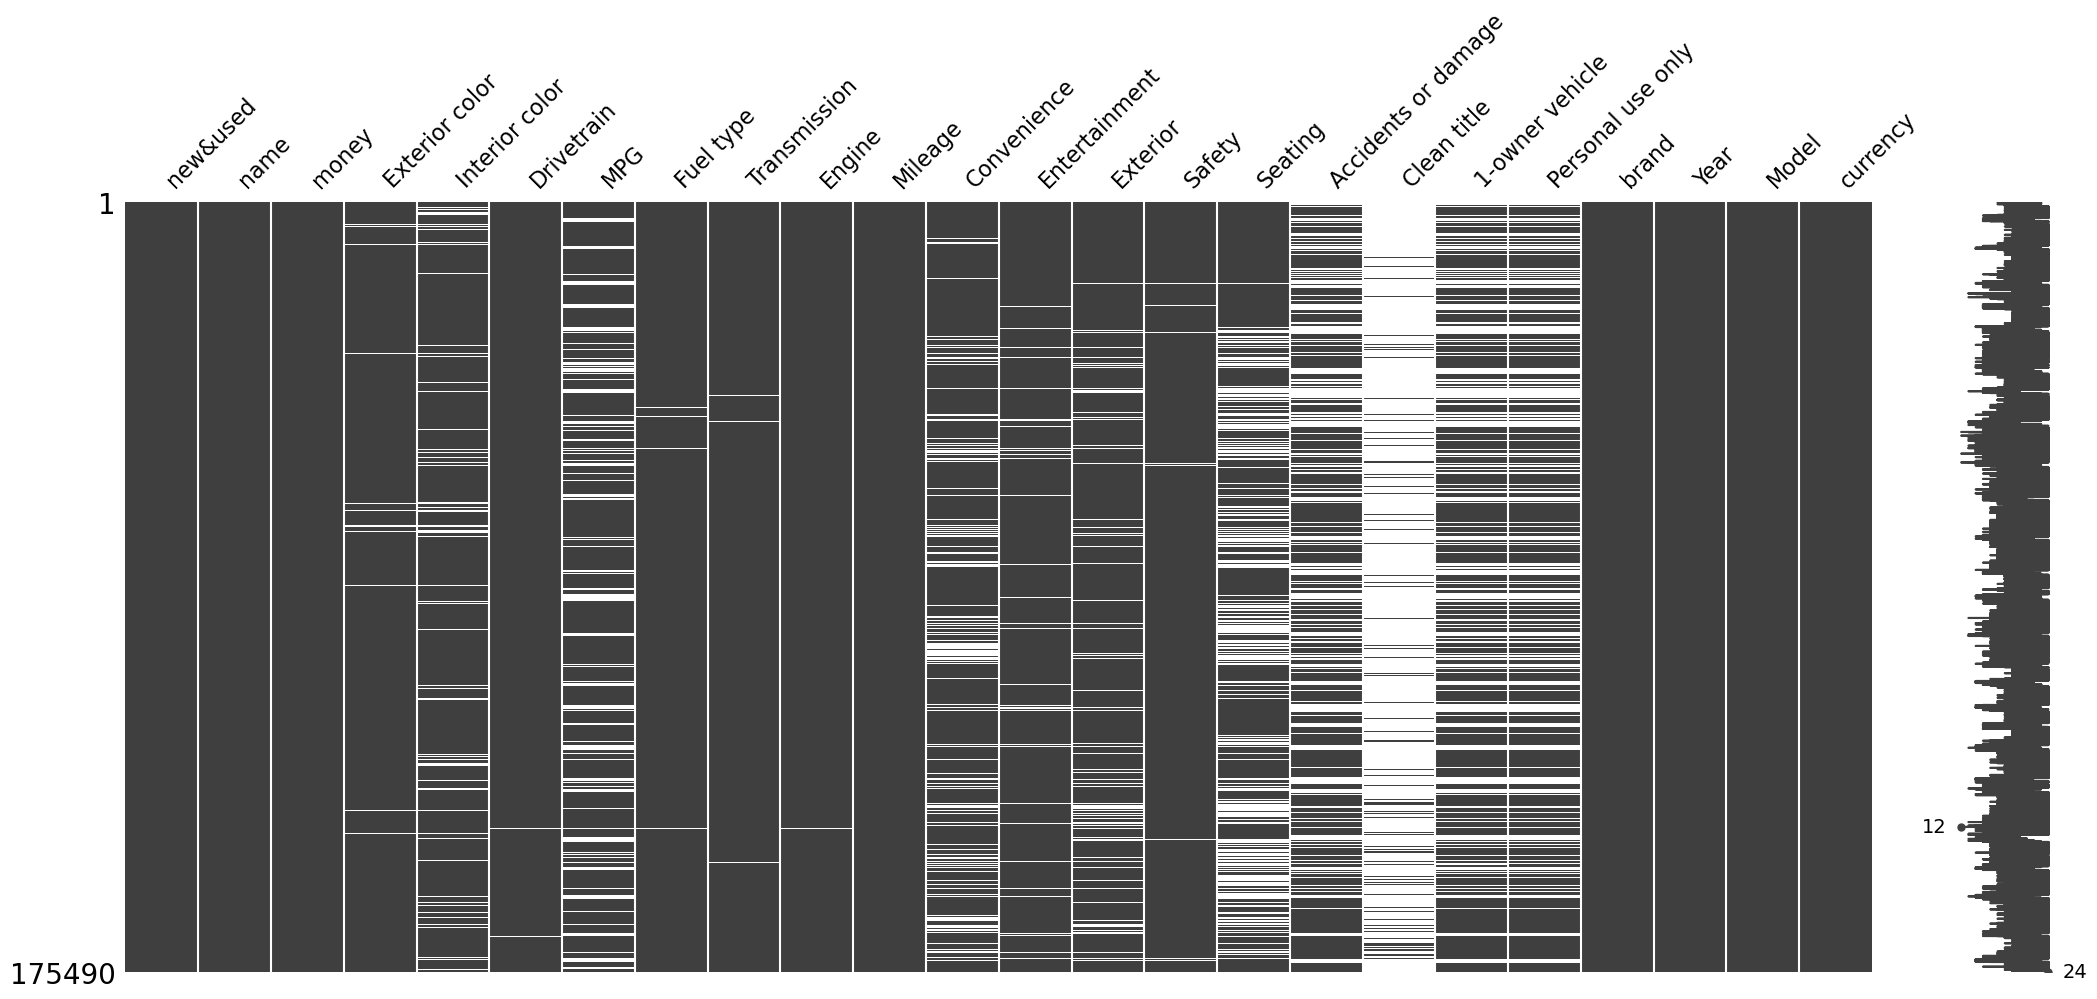

In [18]:
import missingno as msno

# plot a missing data matrix to visualize the missing data for each column
msno.matrix(NY_cars_PDS)

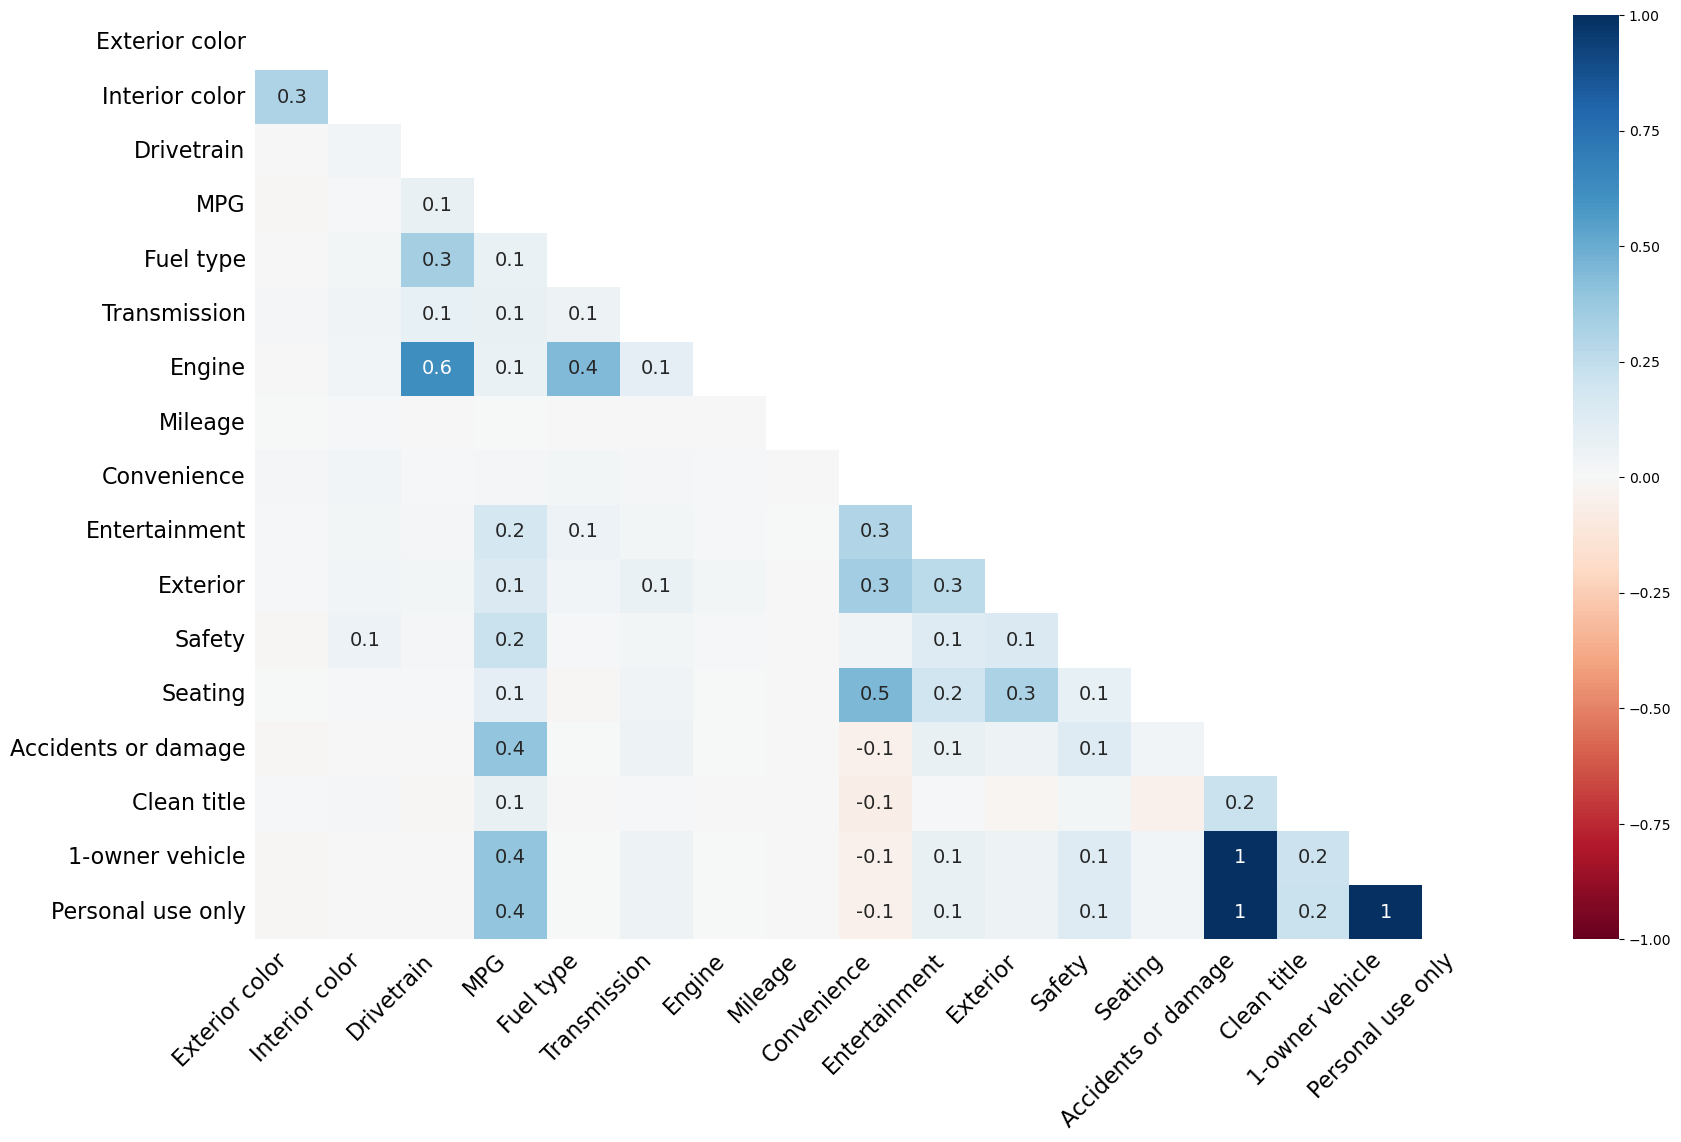

In [19]:
# plot a data "missingess" heatmap to visualize possible relationships between columns in missing data.
msno.heatmap(NY_cars_PDS);

In the context of data analysis, missingness is categorized into three types based on the relationship between the missingness and the observed or unobserved data:

**Missing Completely at Random (MCAR):** The missingness of data has no relationship with any other data, observed or unobserved. It is entirely random.


**Missing at Random (MAR):** The missingness of data is systematically related to other observed data in the dataset but not to the values of the missing data itself. For example, if younger people are less likely to disclose their age, then age is MAR because its missingness is related to another variable in the dataset (in this case, the age group).


**Not Missing at Random (NMAR):** The missingness of data is related to the values of the missing data itself. For instance, if people with higher incomes are less likely to reveal their income, then income is NMAR because its missingness is related to the income value, which is not observed.


The heatmap visualizes the MAR type of missingness. This means that the missing data in the dataset can be predicted by other available information.

### Nullity Correlation Interpretation Examples:
- **Exterior Color & Interior Color (0.3):** This positive correlation suggests that when data is missing for exterior color, it’s also likely to be missing for interior color, and vice versa.
- **Engine & Mileage (0.4):** The positive correlation here indicates that missingness in engine data is often accompanied by missingness in mileage data.
- **Accidents or Damage & Clean Title (-0.4):** The negative correlation means that if accident or damage information is missing, clean title information is likely to be present, and if clean title data is missing, accident or damage data is likely to be present.
- **1-Owner Vehicle & Personal Use Only (1):** A perfect positive correlation implies that if there’s missing data for whether a vehicle had a single owner, there will also be missing data for personal use only, and vice versa.

Handling MAR data requires careful consideration. One common approach is to use multiple imputation, which involves creating several different plausible datasets where the missing values are imputed and then analyzing each dataset to account for the uncertainty around the missing data.


In [20]:
del NY_cars_PDS

In [21]:
# First, we'll find the columns with 10 or less unique values
# from pyspark.sql.functions import col, countDistinct
columns_with_few_uniques = [column for column in NY_cars.columns if NY_cars.agg(countDistinct(col(column)).alias('count')).first()['count'] <= 10]

In [22]:
unique_values_dict = {}
for column in columns_with_few_uniques:
    unique_values = NY_cars.select(column).distinct().rdd.flatMap(lambda x: x).collect()
    unique_values_dict[column] = unique_values

print(unique_values_dict)

{'Drivetrain': ['Rwd', 'Awd', 'Fwd', '4Wd', None], 'Seating': ['  Leather SeatsMemory Seat  ', '  Leather Seats  ', '  Memory SeatThird Row Seating  ', '  Memory Seat  ', '  Leather SeatsThird Row Seating  ', '  Third Row Seating  ', '  Leather SeatsMemory SeatThird Row Seating  ', None], 'Accidents or damage': ['None Reported', 'At Least 1 Accident Or Damage Reported', None], 'Clean title': ['No', 'Yes', None], '1-owner vehicle': ['No', 'Yes', None], 'Personal use only': ['No', 'Yes', None], 'currency': ['$']}


Now, we're going to Transform the Spark DataFrame into a Pandas DataFrame while maintaining the distributed nature of the Spark Dataframe using `to_pandas_on_spark()` instead of `toPandas()`.


**Distributed Nature:** Unlike `toPandas()`, which collects the data to the driver node, `to_pandas_on_spark()` keeps the data distributed across the cluster while enabling the use of the pandas API on a distributed DataFrame, allowing for operations that are familiar to pandas users but executed in a distributed manner.

In [23]:
NY_cars_POS = NY_cars.pandas_api()

/opt/conda/lib/python3.11/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


/opt/conda/lib/python3.11/site-packages/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_list` loads all data into the driver's memory. It should only be used if the resulting list is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/opt/conda/lib/python3.11/site-packages/pyspark/pandas/generic.py:647: UserWarning: We recommend using `Series.to_numpy()` instead.
  warnings.warn("We recommend using `{}.to_numpy()` instead.".format(type(self).__name__))
/opt/conda/lib/python3.11/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


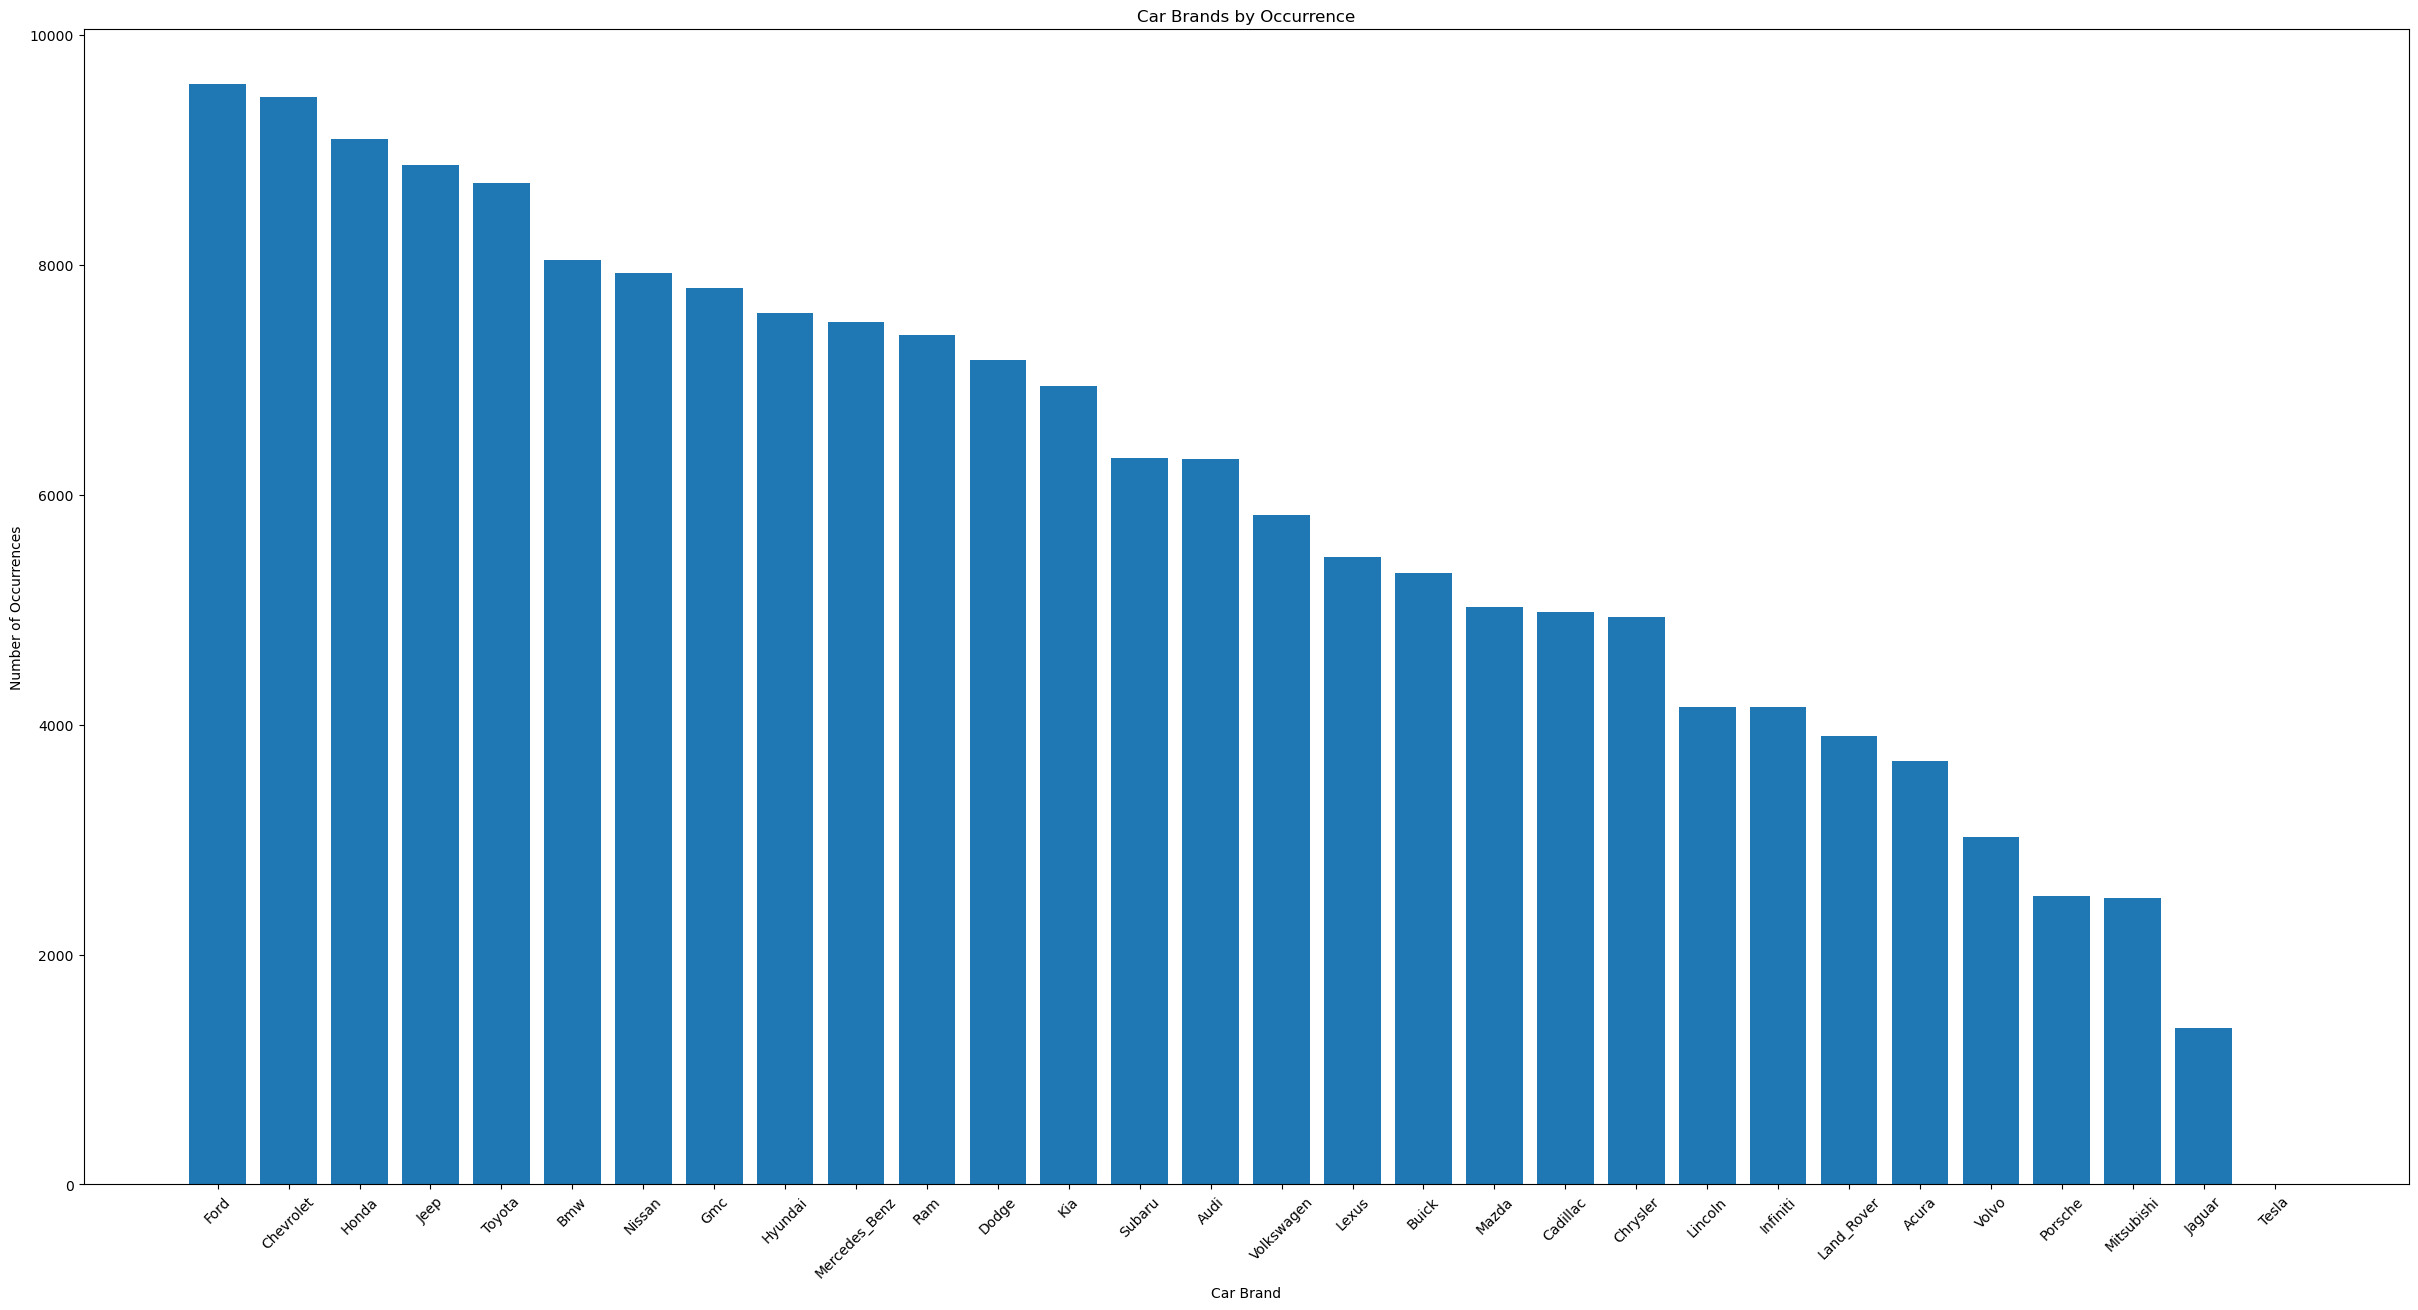

In [24]:
# First, count the occurrences of each car brand
brand_counts = NY_cars_POS['brand'].value_counts().sort_values(ascending=False)

# Convert the index to a list for plotting
brands = brand_counts.index.tolist()
occurrences = brand_counts.values

# Now, create the bar plot using plt.bar
plt.figure(figsize=(30, 15))
plt.bar(brands, occurrences)
plt.title('Car Brands by Occurrence')
plt.xlabel('Car Brand')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


In [25]:
from pyspark.sql.functions import col, split, when, isnan

# Convert 'MPG' to string type and filter out rows with "None"
NY_cars = NY_cars.withColumn("MPG", col("MPG").cast("string"))
NY_cars = NY_cars.filter(~col("MPG").contains("None"))

# Split the 'MPG' column into 'City_MPG' and 'Highway_MPG'
split_col = split(NY_cars['MPG'], '–')
NY_cars = NY_cars.withColumn('City_MPG', split_col.getItem(0).cast("float"))
NY_cars = NY_cars.withColumn('Highway_MPG', split_col.getItem(1).cast("float"))

# Handle possible NaN values after the split (if any)
NY_cars = NY_cars.withColumn('City_MPG', when(col('City_MPG').isNull() | isnan(col('City_MPG')), None).otherwise(col('City_MPG')))
NY_cars = NY_cars.withColumn('Highway_MPG', when(col('Highway_MPG').isNull() | isnan(col('Highway_MPG')), None).otherwise(col('Highway_MPG')))

# Calculate the combined MPG
NY_cars = NY_cars.withColumn('Combined_MPG', (col('City_MPG') + col('Highway_MPG')) / 2)


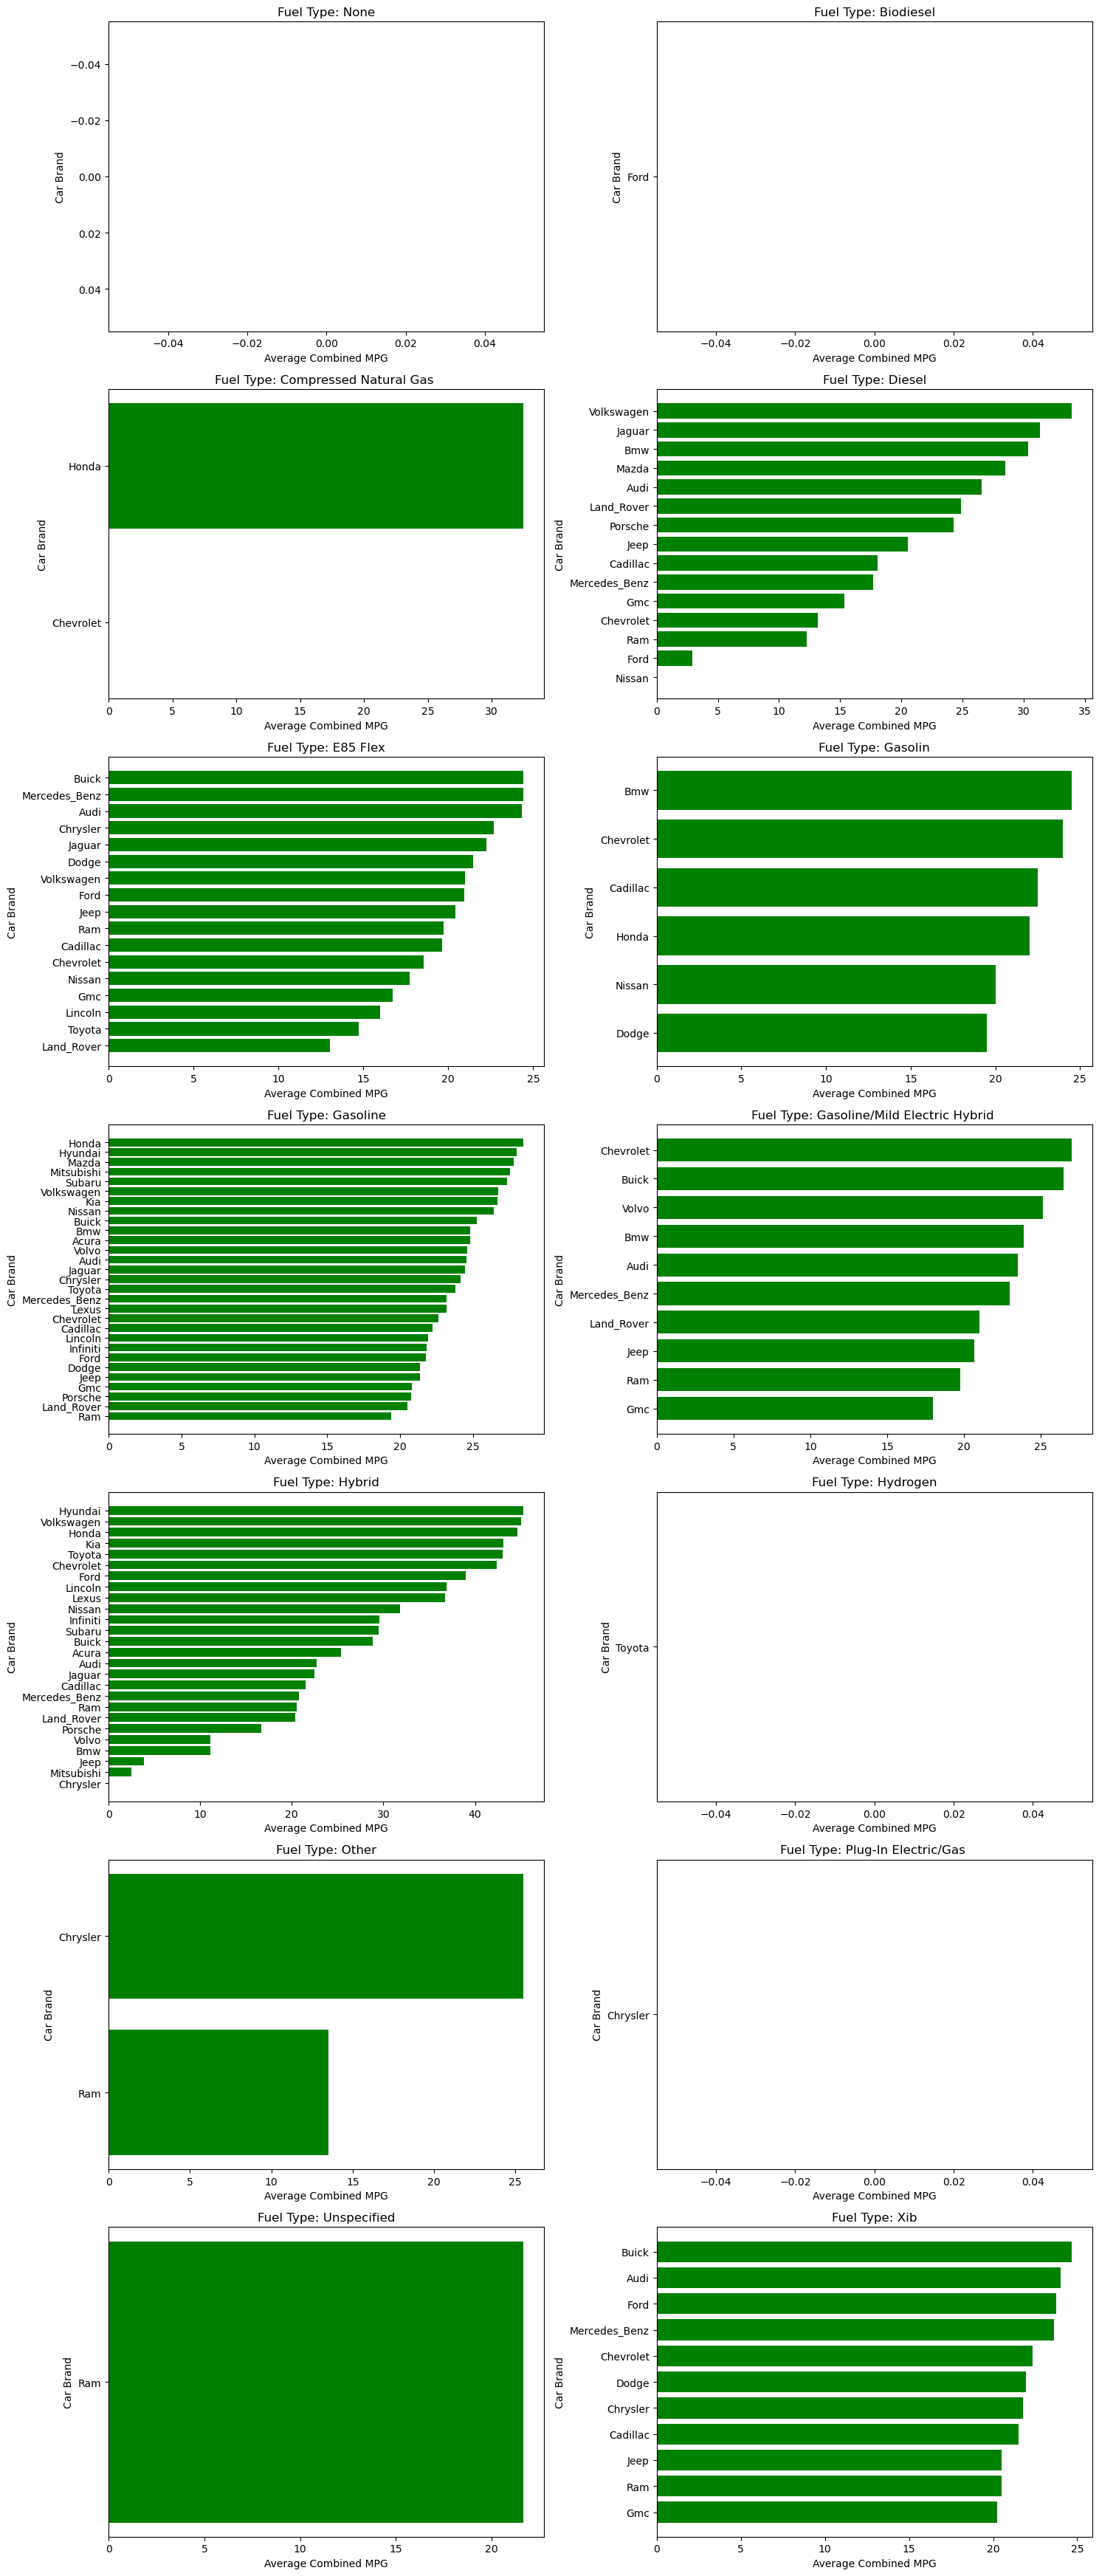

In [26]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F


# Calculate the average combined MPG for each car brand and fuel type
avg_mpg_by_fuel_df = NY_cars.groupBy('brand', 'Fuel type') \
                              .agg(F.avg('Combined_MPG').alias('Average_MPG'))

# Sort the results within each fuel type group in descending order
avg_mpg_by_fuel_df = avg_mpg_by_fuel_df.orderBy('Fuel type', 'Average_MPG', ascending=[True, False])

# Convert to Pandas DataFrame for plotting
pandas_df = avg_mpg_by_fuel_df.toPandas()

# Determine the grid size
fuel_types = pandas_df['Fuel type'].unique()
num_fuel_types = len(fuel_types)
num_columns = 2  # for example, you can choose the number of columns based on your preference
num_rows = (num_fuel_types + 1) // num_columns

# Create a plot matrix for each fuel type
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, fuel_type in enumerate(fuel_types):
    # Filter the DataFrame for the current fuel type
    df_filtered = pandas_df[pandas_df['Fuel type'] == fuel_type]
    
    # Plot the bar plot for the current fuel type
    axes[i].barh(df_filtered['brand'], df_filtered['Average_MPG'], color='green')
    axes[i].set_title(f'Fuel Type: {fuel_type}')
    axes[i].set_xlabel('Average Combined MPG')
    axes[i].set_ylabel('Car Brand')
    axes[i].invert_yaxis()  # To display the highest MPG at the top

# Hide any unused subplots
for j in range(i + 1, num_rows * num_columns):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


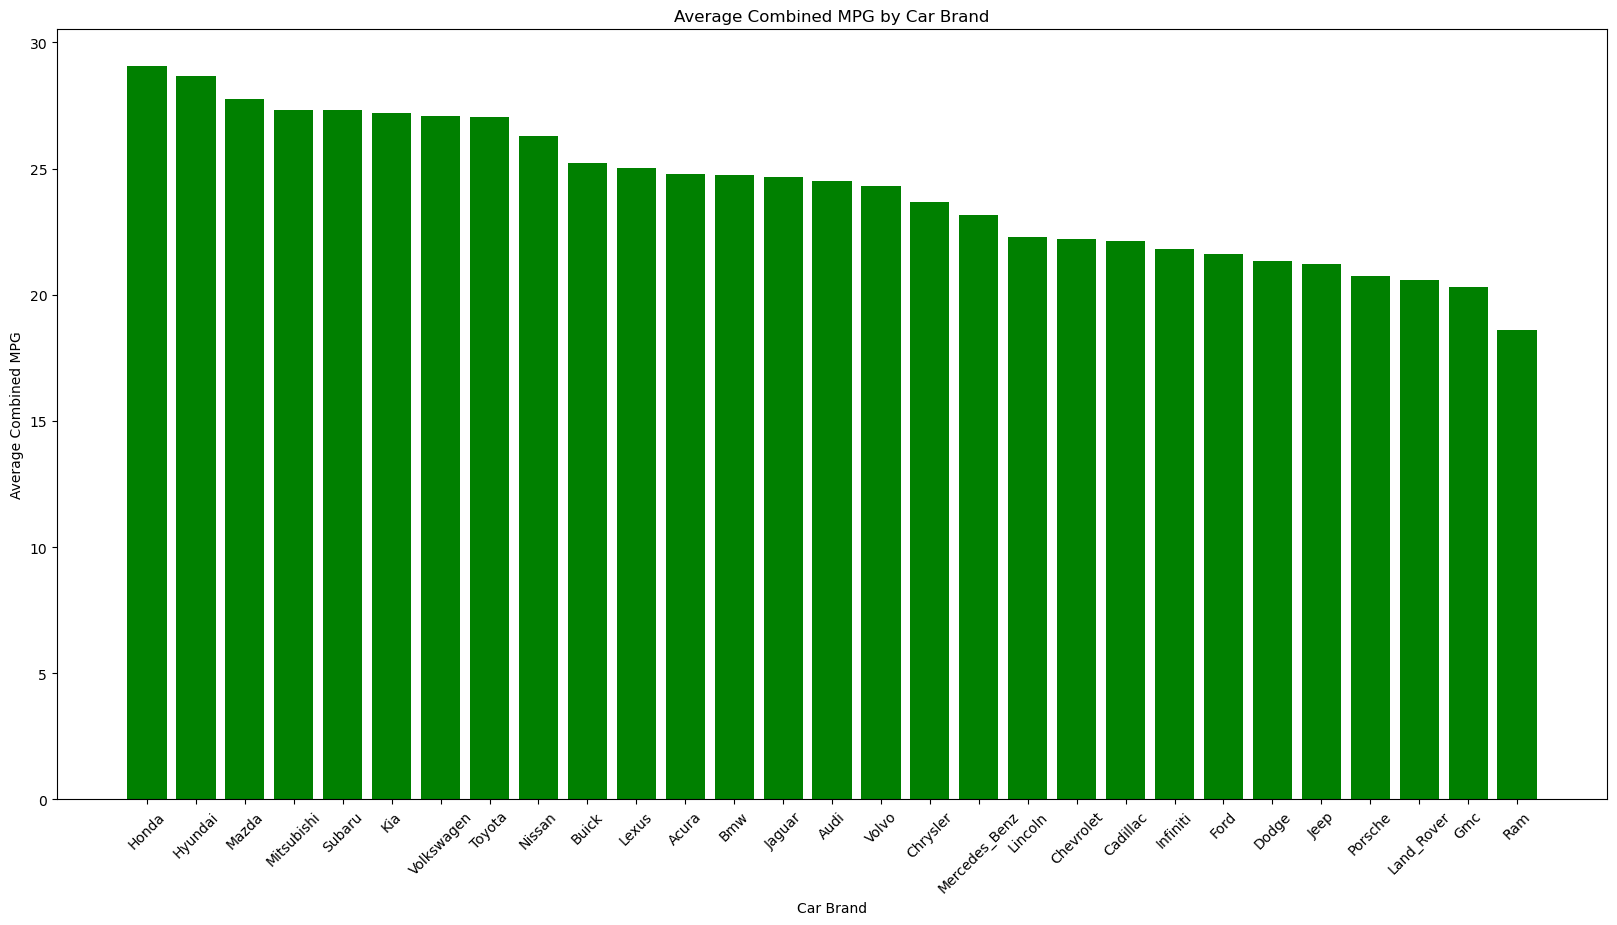

In [27]:
# Calculate the average combined MPG for each car brand
avg_mpg_by_brand_df = NY_cars.groupBy('brand') \
                              .agg(F.avg('Combined_MPG').alias('Average_MPG'))

# Sort the results in descending order
avg_mpg_by_brand_df = avg_mpg_by_brand_df.orderBy('Average_MPG', ascending=False)

# Convert to Pandas DataFrame for plotting
pandas_df = avg_mpg_by_brand_df.toPandas()

# Plot the vertical bar plot for the average MPG by car brand
plt.figure(figsize=(20, 10))
plt.bar(pandas_df['brand'], pandas_df['Average_MPG'], color='green')
plt.ylabel('Average Combined MPG')
plt.xlabel('Car Brand')
plt.title('Average Combined MPG by Car Brand')
plt.xticks(rotation=45)  # Rotate the x-axis labels to show them at a readable angle
plt.show()


#### Now we're going to look into the **question: How do different car brands and models vary in terms of their resale value over time? Analyze trends to provide insights into the best-value purchases.**

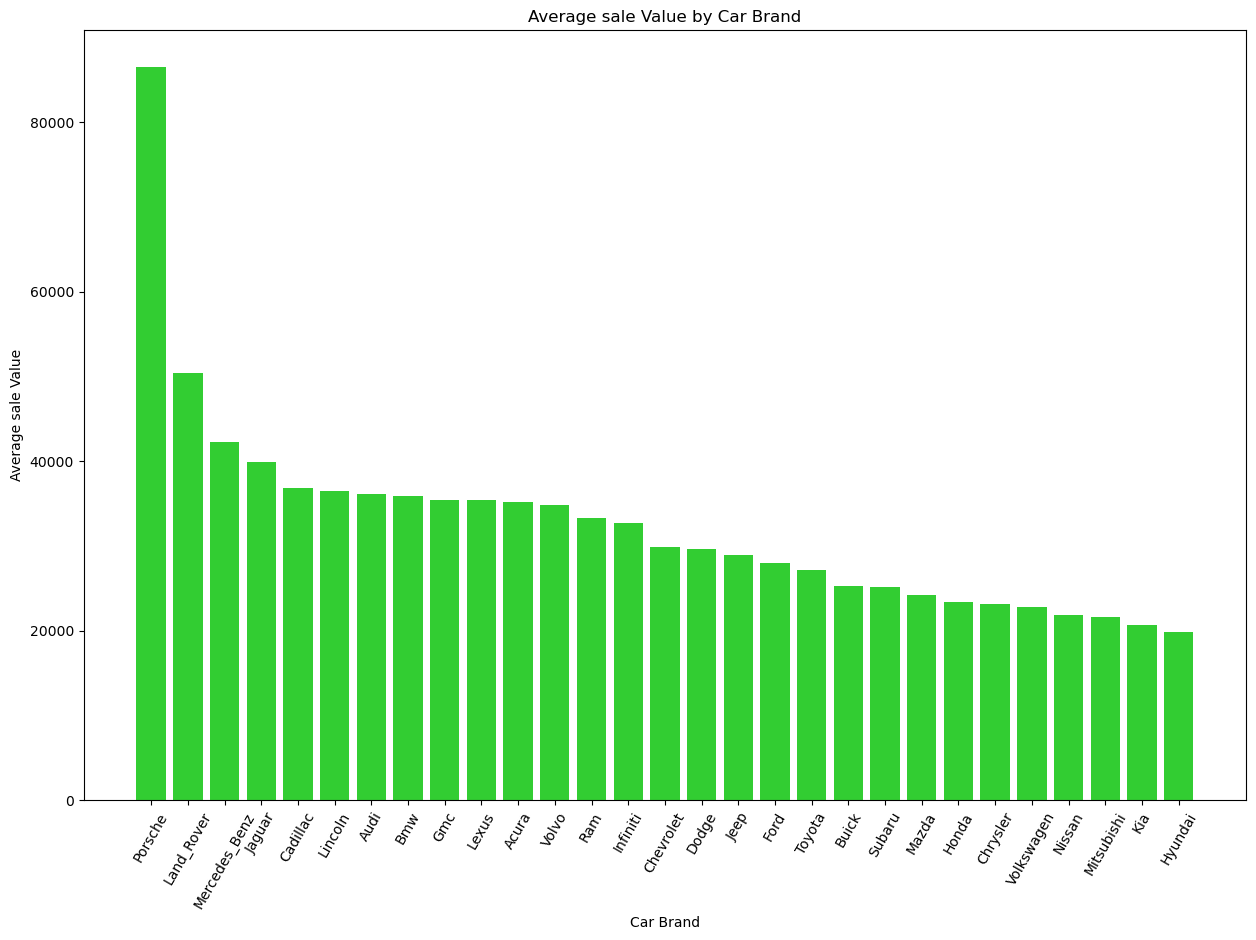

In [28]:
# Calculate the average price for each car brand
avg_price_by_brand_df = NY_cars.groupBy('brand') \
                                .agg(F.avg('money').alias('Average_Price'))

# Sort the results in descending order of average price
avg_price_by_brand_df = avg_price_by_brand_df.orderBy('Average_Price', ascending=False)

# Convert to Pandas DataFrame for plotting
pandas_df = avg_price_by_brand_df.toPandas()

# Plot the vertical bar plot for the average SALE value by car brand
plt.figure(figsize=(15, 10))
plt.bar(pandas_df['brand'], pandas_df['Average_Price'], color='limegreen',)
plt.ylabel('Average sale Value')
plt.xlabel('Car Brand')
plt.title('Average sale Value by Car Brand')
plt.xticks(rotation=60)  # Rotate the x-axis labels to show them vertically
plt.show()


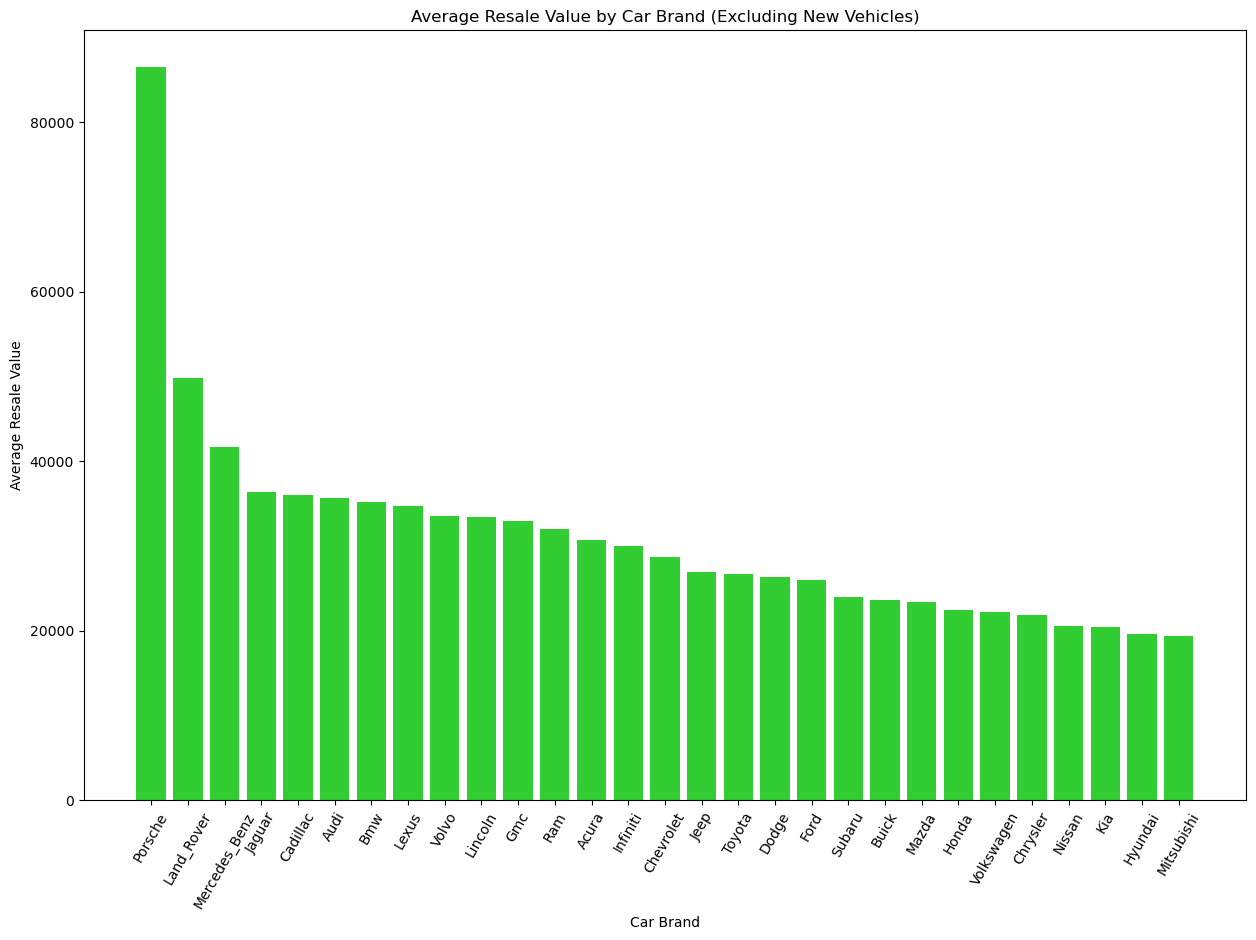

In [29]:
# Filter the DataFrame to exclude vehicles labeled as 'new'
non_new_vehicles_df = NY_cars.filter(~NY_cars['new&used'].contains('New'))

# Calculate the average price for each car brand
avg_price_by_brand_df = non_new_vehicles_df.groupBy('brand') \
                                            .agg(F.avg('money').alias('Average_Price'))

# Sort the results in descending order of average price
avg_price_by_brand_df = avg_price_by_brand_df.orderBy('Average_Price', ascending=False)

# Convert to Pandas DataFrame for plotting
pandas_df = avg_price_by_brand_df.toPandas()

# Plot the vertical bar plot for the average resale value by car brand
plt.figure(figsize=(15, 10))
plt.bar(pandas_df['brand'], pandas_df['Average_Price'], color='limegreen')
plt.ylabel('Average Resale Value')
plt.xlabel('Car Brand')
plt.title('Average Resale Value by Car Brand (Excluding New Vehicles)')
plt.xticks(rotation=60)  # Rotate the x-axis labels to show them at a readable angle
plt.show()


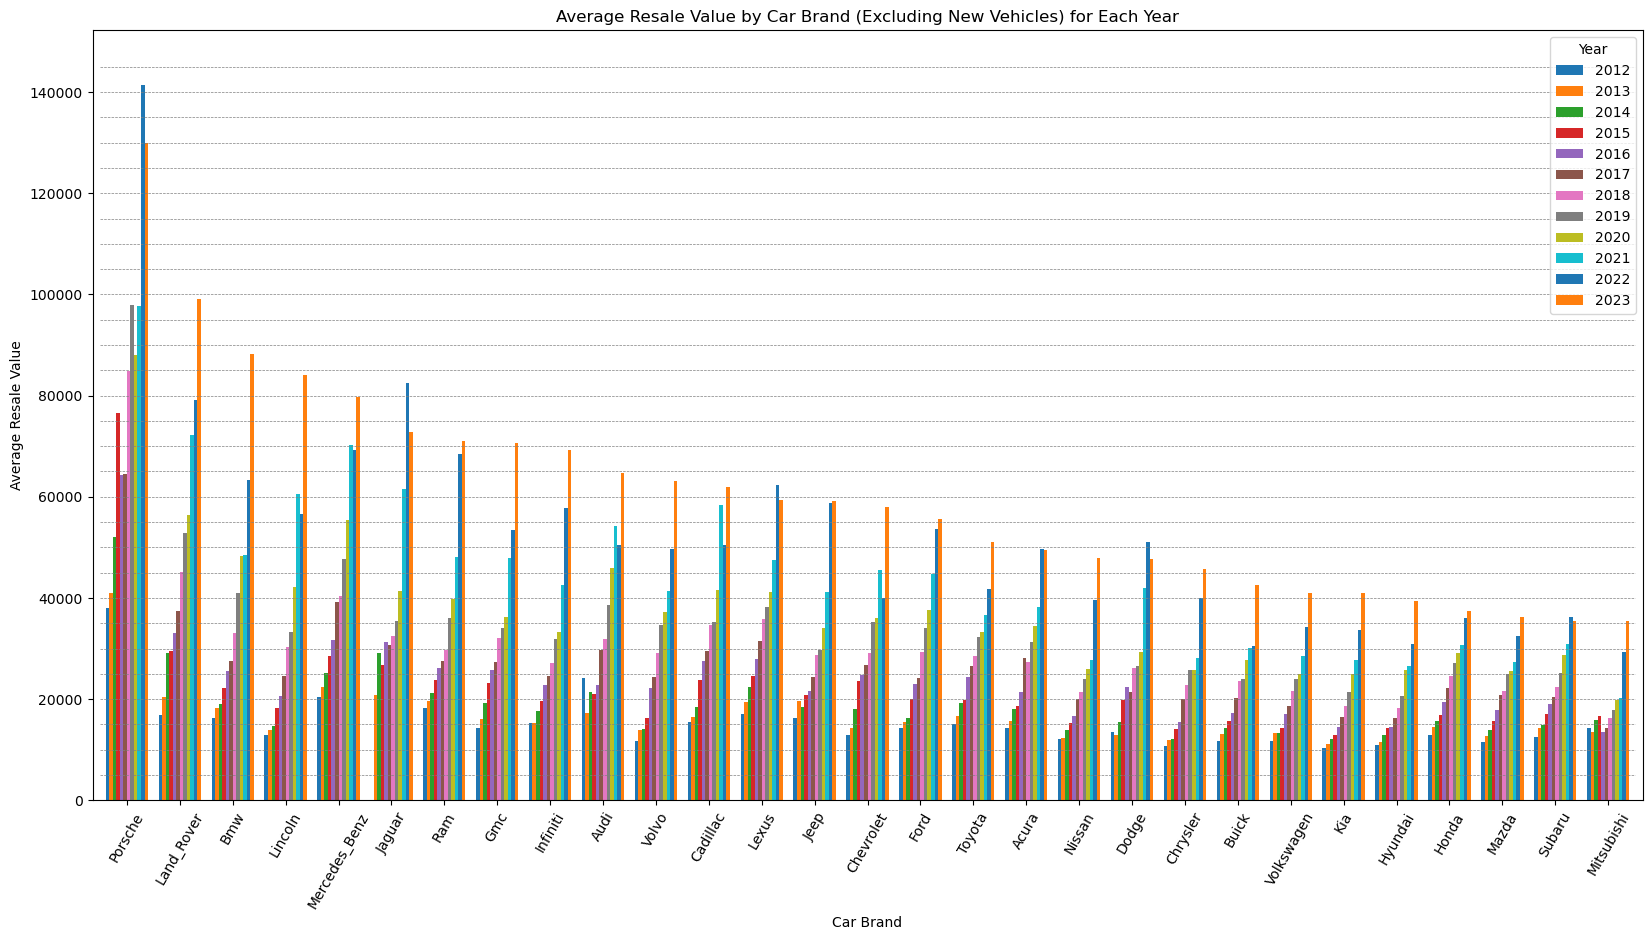

In [30]:
# Filter the DataFrame to exclude vehicles labeled as 'new'
non_new_vehicles_df = NY_cars.filter(~NY_cars['new&used'].contains('new'))

# Calculate the average price for each car brand and year
avg_price_by_brand_year_df = non_new_vehicles_df.groupBy('brand', 'Year') \
                                                 .agg(F.avg('money').alias('Average_Price'))

# Convert to Pandas DataFrame for easier manipulation
pandas_df = avg_price_by_brand_year_df.toPandas()

# Pivot the DataFrame to get 'Year' as columns and 'brand' as rows
pivot_df = pandas_df.pivot(index='brand', columns='Year', values='Average_Price')

# Sort the DataFrame based on the average price of the most recent year

sort_year = max(pivot_df.columns) 

sorted_pivot_df = pivot_df.sort_values(by=sort_year, ascending=False)

# Plot the sorted multivariate bar plot
sorted_pivot_df.plot(kind='bar', figsize=(20, 10), width=0.8)

# Add horizontal dotted lines at specific price points
for price in range(0, int(sorted_pivot_df.max().max()) + 5000, 5000):
    plt.hlines(y=price, xmin=-0.5, xmax=len(sorted_pivot_df.index)-0.5, colors='grey', linestyles='--', lw=0.5)

plt.ylabel('Average Resale Value')
plt.xlabel('Car Brand')
plt.title('Average Resale Value by Car Brand (Excluding New Vehicles) for Each Year')
plt.xticks(rotation=60)  # Rotate the x-axis labels to show them at a readable angle
plt.legend(title='Year')
plt.show()


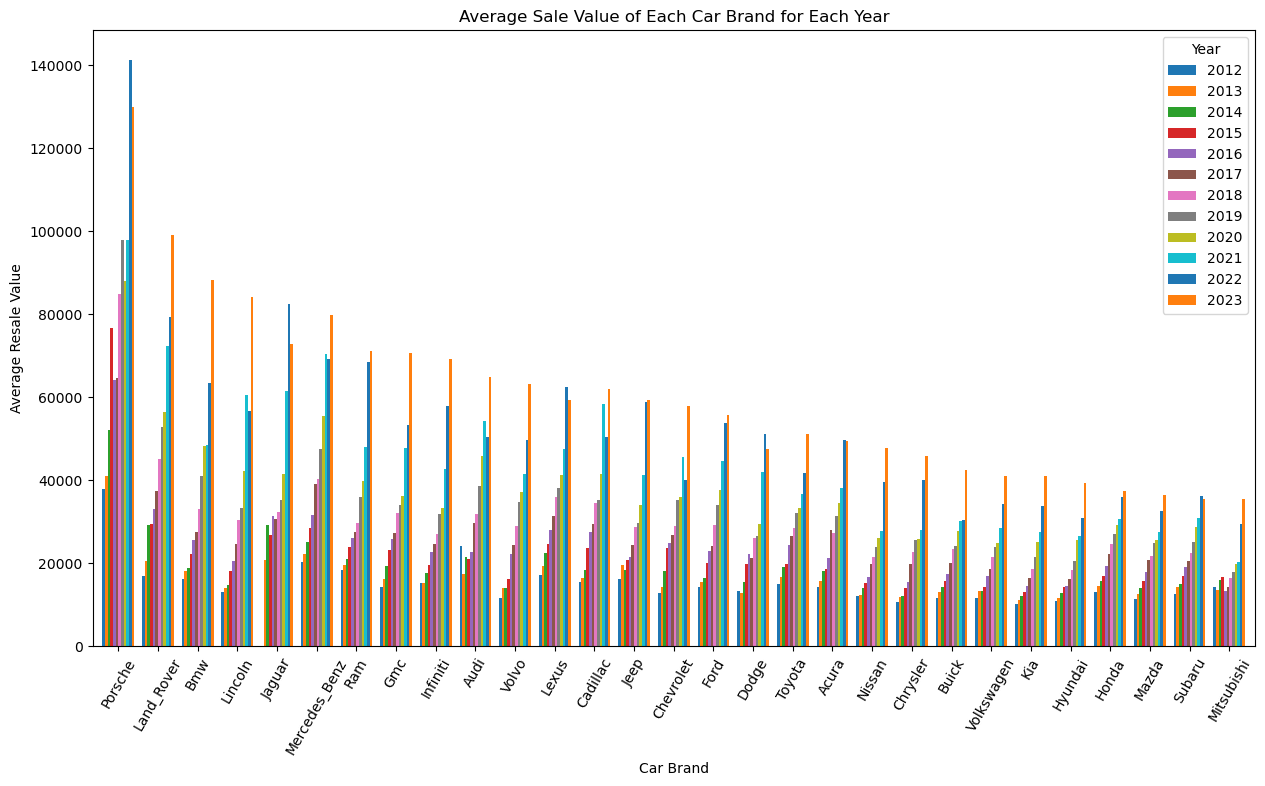

In [31]:
# Calculate the average price for each car brand and year
avg_price_by_brand_year_df = NY_cars.groupBy('brand', 'Year') \
                                     .agg(F.avg('money').alias('Average_Price'))

# Convert to Pandas DataFrame for easier manipulation
pandas_df = avg_price_by_brand_year_df.toPandas()

# Calculate the maximum average price for each brand across all years for sorting
max_avg_price_by_brand = pandas_df.groupby('brand')['Average_Price'].max().sort_values(ascending=False).index

# Pivot the DataFrame to get 'Year' as columns and 'brand' as rows
pivot_df = pandas_df.pivot(index='brand', columns='Year', values='Average_Price')

# Reindex the DataFrame based on the sorted brands
pivot_df = pivot_df.reindex(max_avg_price_by_brand)

# Plot the multivariate bar plot
pivot_df.plot(kind='bar', figsize=(15, 8), width=0.8)
plt.ylabel('Average Resale Value')
plt.xlabel('Car Brand')
plt.title('Average Sale Value of Each Car Brand for Each Year')
plt.xticks(rotation=60)  # Rotate the x-axis labels to show them at a readable angle
plt.legend(title='Year')
plt.show()


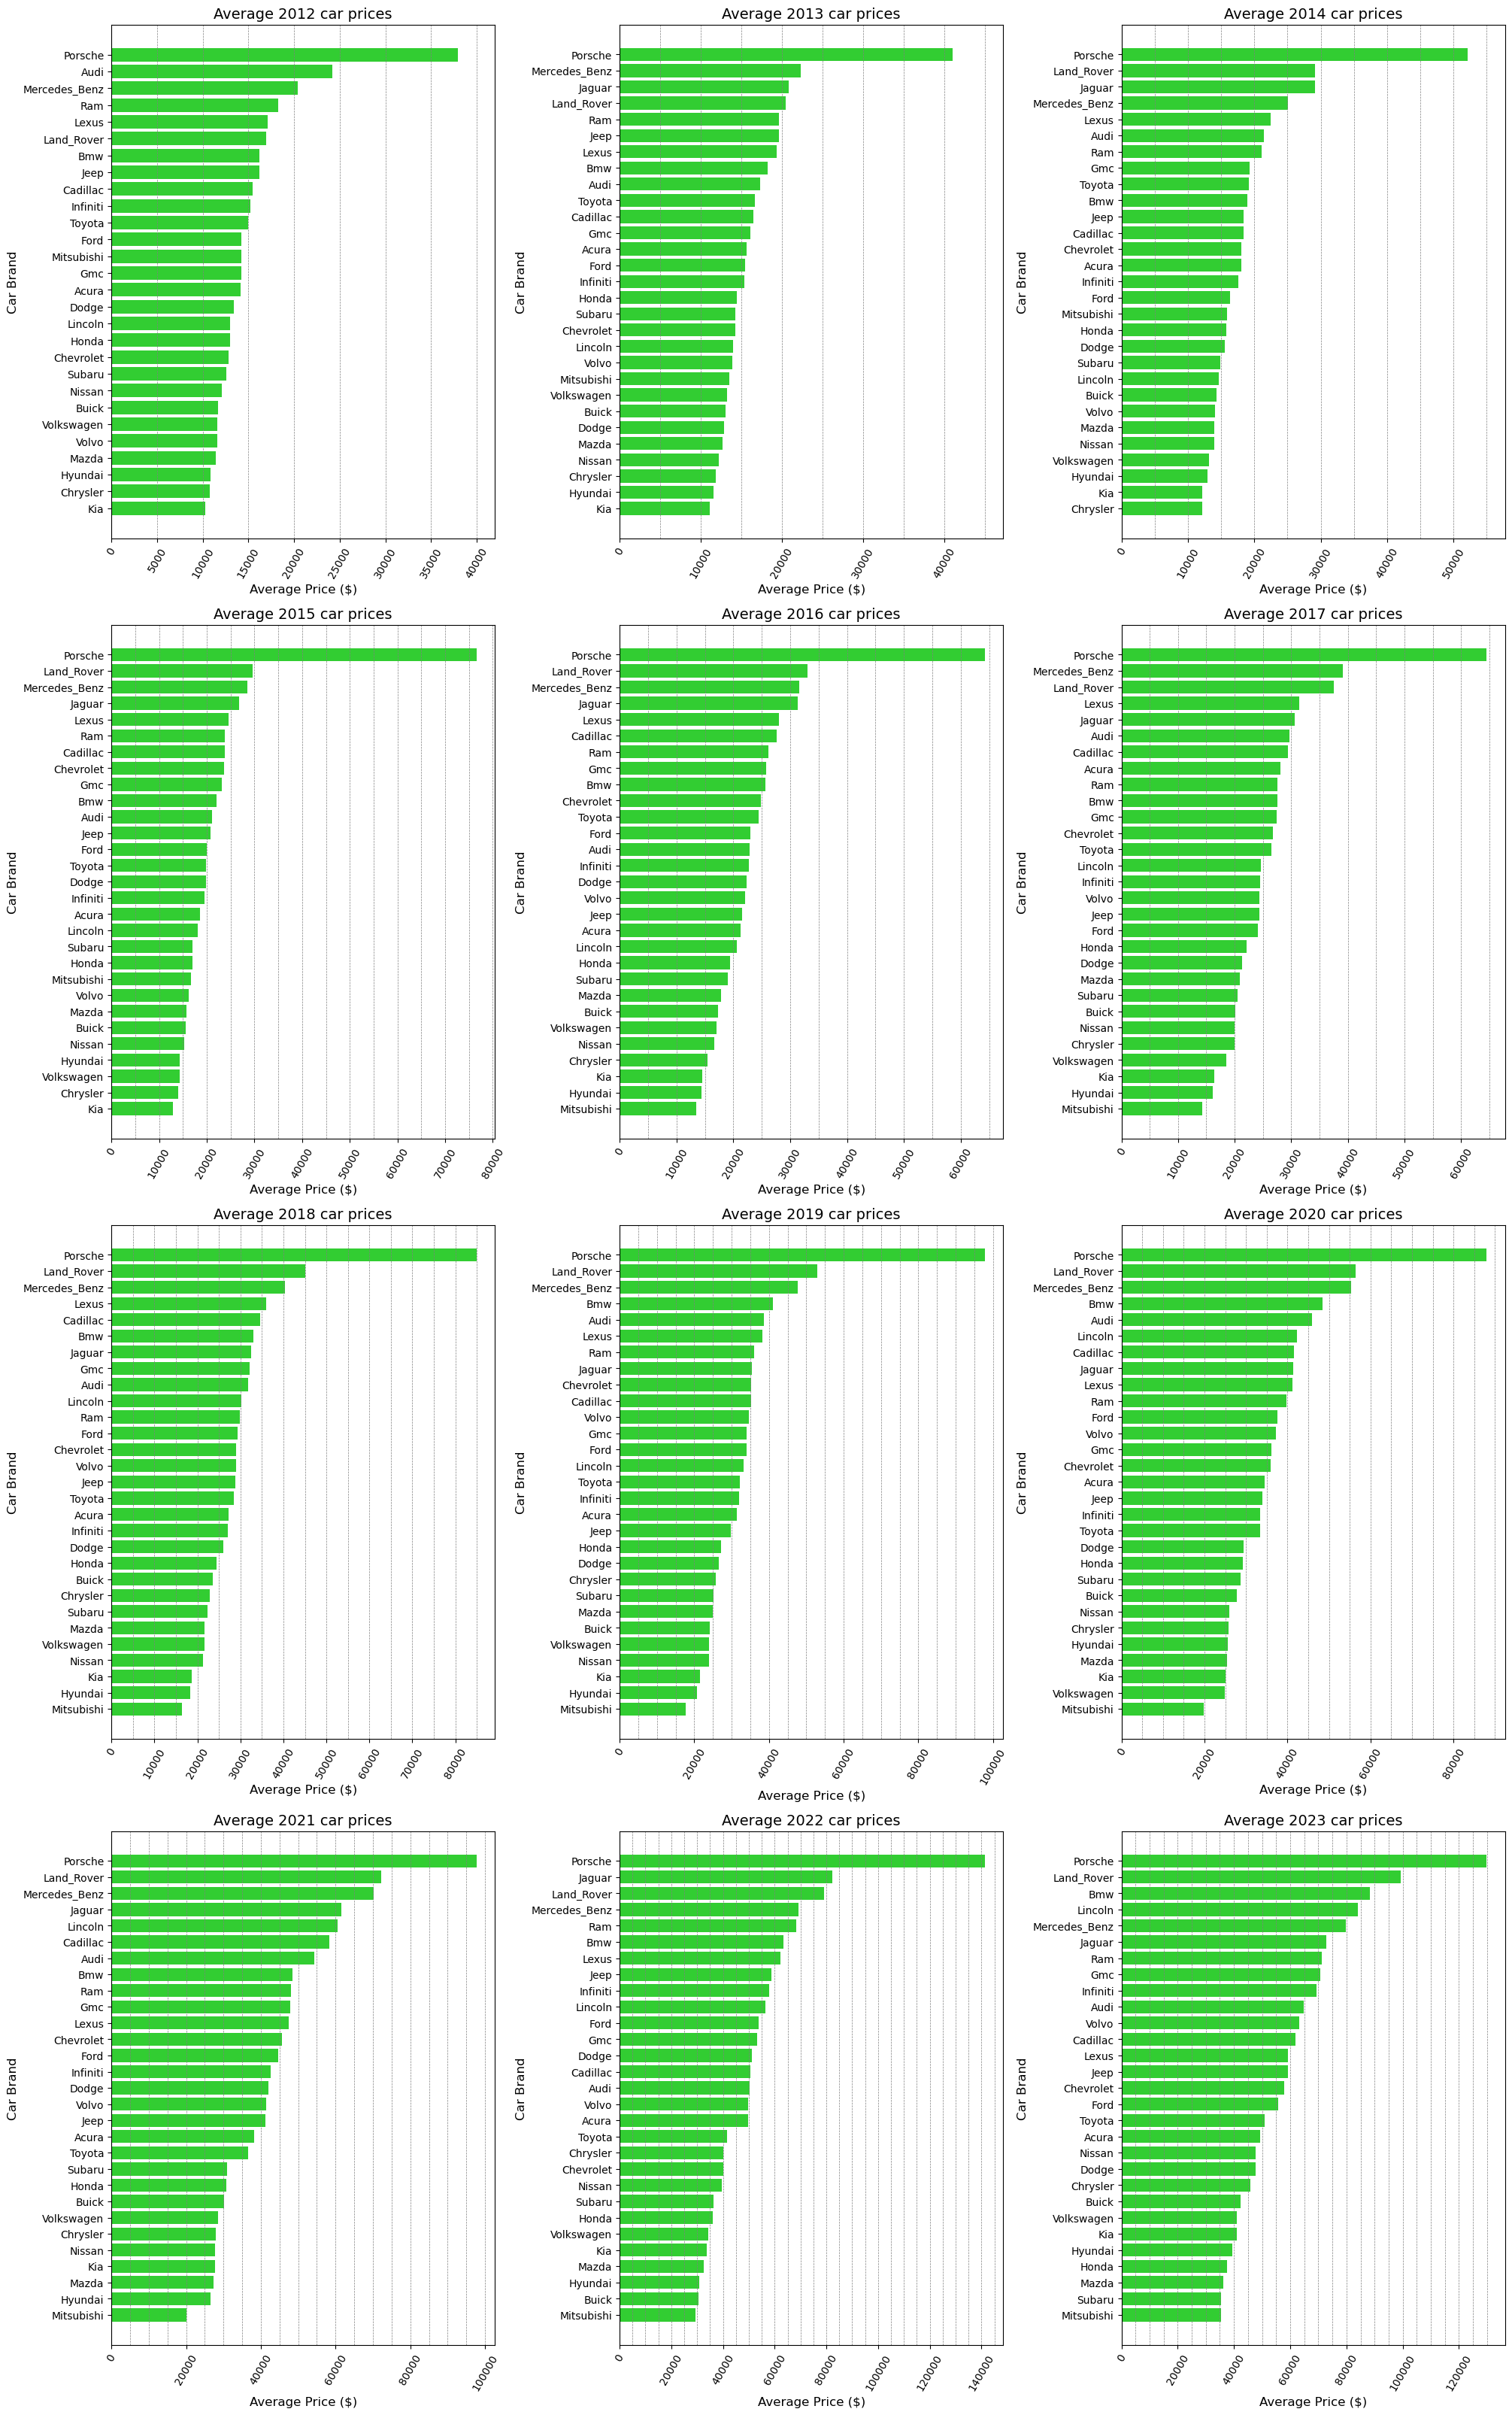

In [32]:
# Calculate the average price for each car brand and year
avg_price_by_brand_year_df = NY_cars.groupBy('brand', 'Year') \
                                     .agg(F.avg('money').alias('Average_Price'))

# Convert to Pandas DataFrame for plotting
pandas_df = avg_price_by_brand_year_df.toPandas()

# Determine the grid layout based on the number of unique years
years = pandas_df['Year'].unique()
num_years = len(years)
num_columns = 3  # Optimal for display
num_rows = -(-num_years // num_columns)  # Ceiling division to calculate rows

# Create a subplot for each year
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 8), constrained_layout=True)
axes = axes.flatten()  # Flatten for easy iteration

# Define the interval for the vertical lines
interval = 5000

# Plot each year's average prices in a separate subplot
for i, year in enumerate(sorted(years)):
    df_filtered = pandas_df[pandas_df['Year'] == year].sort_values(by='Average_Price', ascending=False)
    ax = axes[i]  # Current axis
    brands = df_filtered['brand']
    prices = df_filtered['Average_Price']
    
    # Bar plot for the current year
    ax.barh(brands, prices, color='limegreen')
    
    # Determine the x-axis limits to place vertical lines correctly
    max_price = prices.max()
    # Add vertical dotted lines at specified intervals
    for x in range(0, int(max_price) + interval, interval):
        ax.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)
    
    # Set titles and labels
    ax.set_title(f'Average {year} car prices', fontsize=14)
    ax.set_xlabel('Average Price ($)', fontsize=12)
    ax.set_ylabel('Car Brand', fontsize=12)
    ax.tick_params(axis='x', labelrotation=60)
    ax.invert_yaxis()  # Highest price at top

# Remove unused subplots
for j in range(i + 1, num_rows * num_columns):
    fig.delaxes(axes[j])

plt.show()


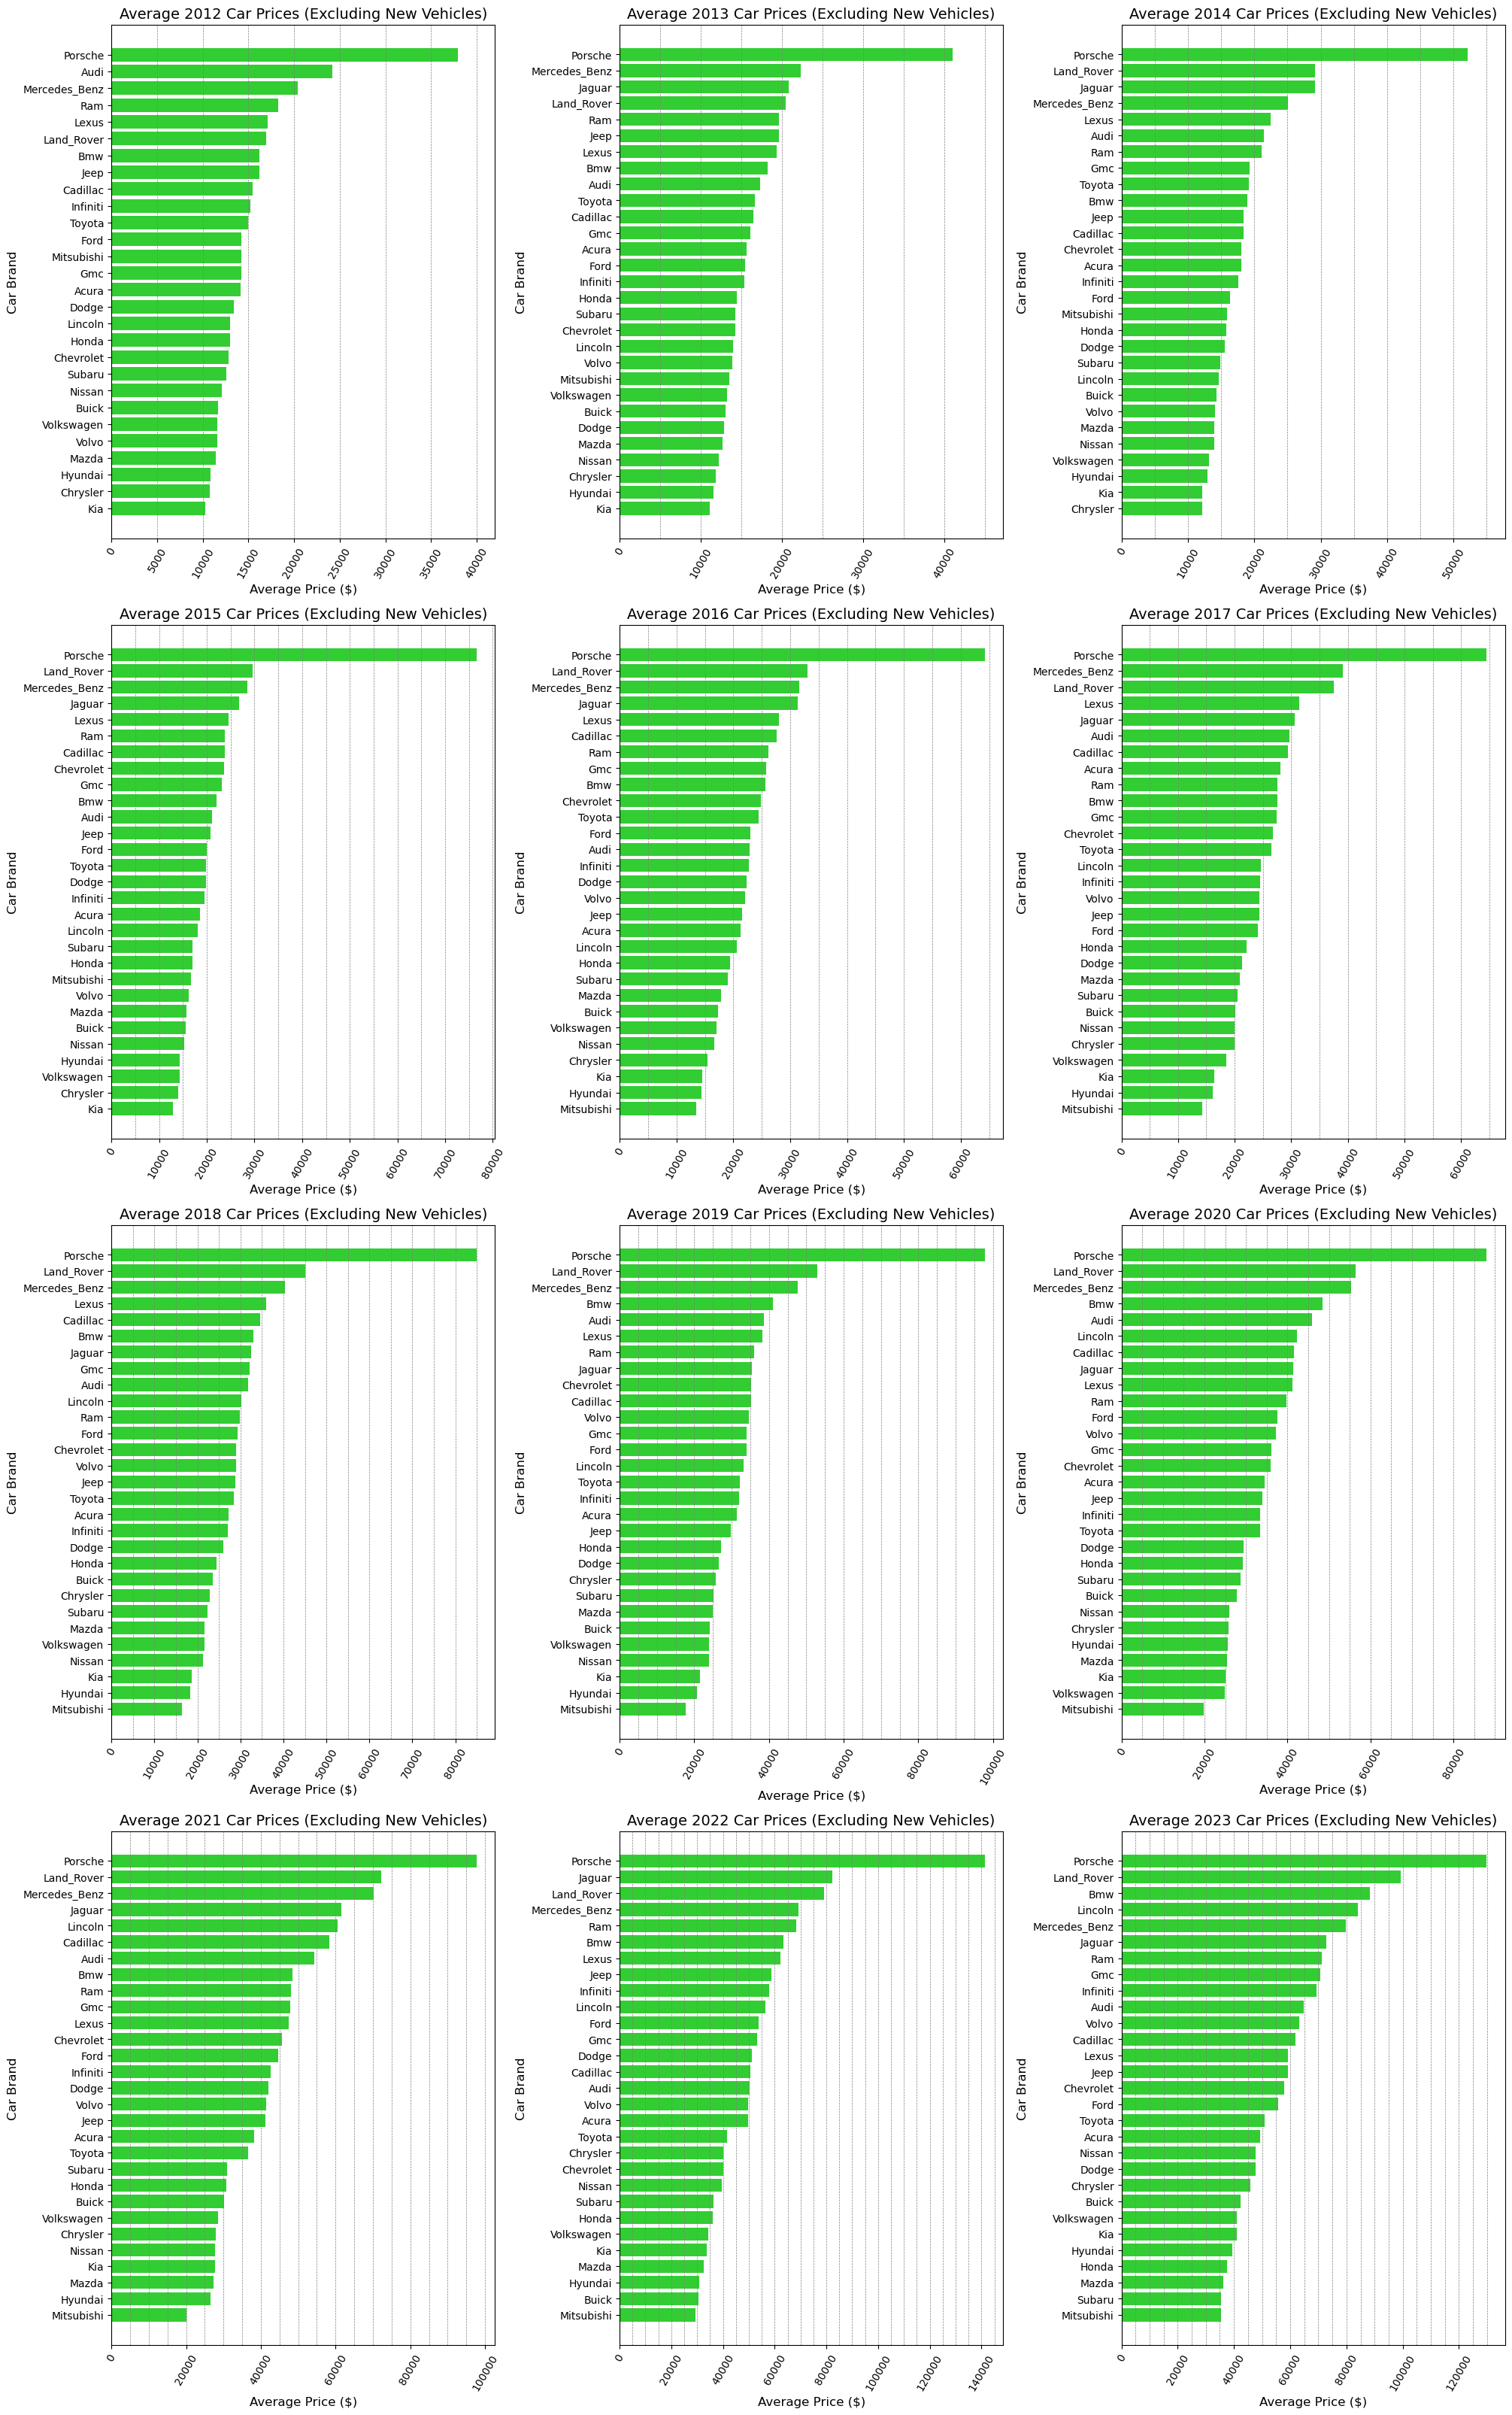

In [33]:
# Filter the DataFrame to exclude vehicles labeled as 'new'
non_new_vehicles_df = NY_cars.filter(~NY_cars['new&used'].contains('new'))

# Calculate the average price for each car brand and year
avg_price_by_brand_year_df = non_new_vehicles_df.groupBy('brand', 'Year') \
                                                 .agg(F.avg('money').alias('Average_Price'))

# Convert to Pandas DataFrame for plotting
pandas_df = avg_price_by_brand_year_df.toPandas()

# Determine the grid layout based on the number of unique years
years = pandas_df['Year'].unique()
num_years = len(years)
num_columns = 3  # Optimal for display
num_rows = -(-num_years // num_columns)  # Ceiling division to calculate rows

# Create a subplot for each year
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 8), constrained_layout=True)
axes = axes.flatten()  # Flatten for easy iteration

# Define the interval for the vertical lines
interval = 5000

# Plot each year's average prices in a separate subplot
for i, year in enumerate(sorted(years)):
    df_filtered = pandas_df[pandas_df['Year'] == year].sort_values(by='Average_Price', ascending=False)
    ax = axes[i]  # Current axis
    brands = df_filtered['brand']
    prices = df_filtered['Average_Price']
    
    # Bar plot for the current year
    ax.barh(brands, prices, color='limegreen')
    
    # Determine the x-axis limits to place vertical lines correctly
    max_price = prices.max()
    # Add vertical dotted lines at specified intervals
    for x in range(0, int(max_price) + interval, interval):
        ax.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)
    
    # Set titles and labels
    ax.set_title(f'Average {year} Car Prices (Excluding New Vehicles)', fontsize=14)
    ax.set_xlabel('Average Price ($)', fontsize=12)
    ax.set_ylabel('Car Brand', fontsize=12)
    ax.tick_params(axis='x', labelrotation=60)
    ax.invert_yaxis()  # Highest price at top

# Remove unused subplots
for j in range(i + 1, num_rows * num_columns):
    fig.delaxes(axes[j])

plt.show()


The results are perfectly plausible with luxury brands leading the pack especially limited production run almost collector's edition sports luxury cars like **Porsche** which  are known to retain value if now increase their value with time with some limited edition vehicles.

Now we're going to look into the overall highest price models for all cars new and used and then look into the best resale value cars for non-new cars.

In [34]:
# Calculate the average price for each car brand and year
avg_price_by_brand_year_df = NY_cars.groupBy('brand', 'Year') \
                                     .agg(F.avg('money').alias('Average_Price'))

# Create a window partitioned by Year and ordered by Average_Price descending
windowSpec = Window.partitionBy('Year').orderBy(F.desc('Average_Price'))

# Use the window spec to add a rank for each brand within each year
ranked_brands_df = avg_price_by_brand_year_df.withColumn('rank', F.rank().over(windowSpec))

# Filter for the top 5 brands for each year
top_brands_df = ranked_brands_df.filter(ranked_brands_df['rank'] <= 5)

# Collect the results as a list of Rows
top_brands_list = top_brands_df.collect()

# Convert the list of Rows into a dictionary with years as keys and top brands as values
top_brands_dict = {}
for row in top_brands_list:
    year = row['Year']
    brand = row['brand']
    if year not in top_brands_dict:
        top_brands_dict[year] = [brand]
    else:
        top_brands_dict[year].append(brand)

# Print the dictionary
for year, brands in top_brands_dict.items():
    print(f"Top 5 brands for {year}: {brands}")


Top 5 brands for 2012: ['Porsche', 'Audi', 'Mercedes_Benz', 'Ram', 'Lexus']
Top 5 brands for 2013: ['Porsche', 'Mercedes_Benz', 'Jaguar', 'Land_Rover', 'Ram']
Top 5 brands for 2014: ['Porsche', 'Land_Rover', 'Jaguar', 'Mercedes_Benz', 'Lexus']
Top 5 brands for 2015: ['Porsche', 'Land_Rover', 'Mercedes_Benz', 'Jaguar', 'Lexus']
Top 5 brands for 2016: ['Porsche', 'Land_Rover', 'Mercedes_Benz', 'Jaguar', 'Lexus']
Top 5 brands for 2017: ['Porsche', 'Mercedes_Benz', 'Land_Rover', 'Lexus', 'Jaguar']
Top 5 brands for 2018: ['Porsche', 'Land_Rover', 'Mercedes_Benz', 'Lexus', 'Cadillac']
Top 5 brands for 2019: ['Porsche', 'Land_Rover', 'Mercedes_Benz', 'Bmw', 'Audi']
Top 5 brands for 2020: ['Porsche', 'Land_Rover', 'Mercedes_Benz', 'Bmw', 'Audi']
Top 5 brands for 2021: ['Porsche', 'Land_Rover', 'Mercedes_Benz', 'Jaguar', 'Lincoln']
Top 5 brands for 2022: ['Porsche', 'Jaguar', 'Land_Rover', 'Mercedes_Benz', 'Ram']
Top 5 brands for 2023: ['Porsche', 'Land_Rover', 'Bmw', 'Lincoln', 'Mercedes_Benz'

In [35]:
# Sample dictionary with top five brands for each year
top_brands_dict


# Initialize a dictionary to count the frequency of each brand's appearance
brand_frequency = {}

# Iterate over each year in the dictionary
for year, brands in top_brands_dict.items():
    for brand in brands:
        if brand not in brand_frequency:
            brand_frequency[brand] = 1
        else:
            brand_frequency[brand] += 1

# Sort the brands by their frequency, highest first
sorted_brands = sorted(brand_frequency.items(), key=lambda x: x[1], reverse=True)

# Print the sorted list of brands
print("Brands ranked by their frequency in the top five:")
for brand, frequency in sorted_brands:
    print(f"{brand}: {frequency} times")


Brands ranked by their frequency in the top five:
Porsche: 12 times
Mercedes_Benz: 12 times
Land_Rover: 11 times
Jaguar: 7 times
Lexus: 6 times
Audi: 3 times
Ram: 3 times
Bmw: 3 times
Lincoln: 2 times
Cadillac: 1 times


In [36]:
# Sample dictionary with top five brands for each year
top_brands_dict

# Initialize a dictionary to hold the scores for each brand
brand_scores = {}

# Assign points for each placement within the top five
points_for_placement = {1: 5, 2: 4, 3: 3, 4: 2, 5: 1}

# Iterate over each year and each brand's placement
for year, brands in top_brands_dict.items():
    for placement, brand in enumerate(brands, start=1):
        if brand not in brand_scores:
            brand_scores[brand] = 0
        brand_scores[brand] += points_for_placement[placement]

# Sort the brands by their total score, highest first
sorted_brands_by_score = sorted(brand_scores.items(), key=lambda x: x[1], reverse=True)

# Determine the best top five brands of all time based on the total score
best_top_five_brands = sorted_brands_by_score[:5]

# Print the best top five brands
print("Best top five brands of all time based on score:")
for brand, score in best_top_five_brands:
    print(f"{brand}: {score} points")


Best top five brands of all time based on score:
Porsche: 60 points
Land_Rover: 40 points
Mercedes_Benz: 34 points
Jaguar: 17 points
Lexus: 8 points


In [37]:
# Aggregate Sale Prices
avg_price_by_model_year_df = NY_cars.groupBy('Model', 'Year') \
                                    .agg(F.avg('money').alias('Average_Price'))

# Rank Models Annually
windowSpec = Window.partitionBy('Year').orderBy(F.desc('Average_Price'))
ranked_models_df = avg_price_by_model_year_df.withColumn('rank', F.rank().over(windowSpec))
top_models_annual_df = ranked_models_df.filter(ranked_models_df['rank'] <= 10)

# Convert to Pandas DataFrame for easier manipulation
top_models_annual_pandas = top_models_annual_df.toPandas()

# Count Occurrences and Step 4: Assign Scores
model_occurrences = {}
model_scores = {}
points_for_placement = {1: 10, 2: 9, 3: 8, 4: 7, 5: 6, 6: 5, 7: 4, 8: 3, 9: 2, 10: 1}

for index, row in top_models_annual_pandas.iterrows():
    model = row['Model']
    rank = row['rank']
    model_occurrences[model] = model_occurrences.get(model, 0) + 1
    model_scores[model] = model_scores.get(model, 0) + points_for_placement[rank]

# Determine All-Time Top 10
# Sort models by occurrences and then by score
sorted_models_by_occurrences = sorted(model_occurrences.items(), key=lambda x: (-x[1], -model_scores[x[0]]))

# Select the top 10 models
all_time_top_10_models = sorted_models_by_occurrences[:10]

# Print the all-time top 10 models
print("All-Time Top 10 Best-Selling Car Models:")
for model, occurrences in all_time_top_10_models:
    print(f"{model}: {occurrences} occurrences, {model_scores[model]} points")


All-Time Top 10 Best-Selling Car Models:
911 Turbo S: 11 occurrences, 75 points
911 Turbo: 9 occurrences, 39 points
911 Gt3: 5 occurrences, 34 points
Amg G 63 Base: 3 occurrences, 18 points
911 Targa 4S: 3 occurrences, 5 points
911 Targa 4 Gts: 3 occurrences, 3 points
Sls Amg Gt: 2 occurrences, 20 points
911 Gt2 Rs: 2 occurrences, 20 points
Srt Viper Gts: 2 occurrences, 18 points
911 Gt3 Rs: 2 occurrences, 16 points


In [38]:
# Filter out 'new' cars
non_new_vehicles_df = NY_cars.filter(~NY_cars['new&used'].contains('new'))

# Calculate the average sale price for each car model and year
avg_price_by_model_year_df = non_new_vehicles_df.groupBy('Model', 'Year') \
                                                 .agg(F.avg('money').alias('Average_Price'))

# Define a window spec to rank models within each year by average sale price
windowSpec = Window.partitionBy('Year').orderBy(F.desc('Average_Price'))

# Rank models and get the top 50 for each year
top_models_df = avg_price_by_model_year_df.withColumn('rank', F.rank().over(windowSpec)) \
                                          .filter(F.col('rank') <= 50)

# Collect the results as a list of Rows
top_models_list = top_models_df.collect()

# Initialize dictionaries to count occurrences and calculate scores
model_occurrences = {}
model_scores = {}

# Assign points based on ranking (50 points for 1st place, 49 for 2nd, etc.)
for row in top_models_list:
    model = row['Model']
    rank = row['rank']
    model_occurrences[model] = model_occurrences.get(model, 0) + 1
    model_scores[model] = model_scores.get(model, 0) + (51 - rank)

# Sort models by occurrences and then by score
sorted_models_by_occurrences = sorted(model_occurrences.items(), key=lambda x: -x[1])
sorted_models_by_score = sorted(model_scores.items(), key=lambda x: -x[1])

# Get the top 50 models of all time by occurrences and by score
top_50_models_by_occurrences = sorted_models_by_occurrences[:50]
top_50_models_by_score = sorted_models_by_score[:50]

# Print the top 50 models by occurrences
print("Top 50 Car Models of All Time by Occurrence:")
for model, occurrences in top_50_models_by_occurrences:
    print(f"{model}: {occurrences} occurrences")

# Print the top 50 models by score
print("\n \n \nTop 50 Car Models of All Time by Score:")
for model, score in top_50_models_by_score:
    print(f"{model}: {score} points")


Top 50 Car Models of All Time by Occurrence:
911 Turbo S: 11 occurrences
911 Carrera 4S: 11 occurrences
911 Carrera: 11 occurrences
911 Carrera S: 10 occurrences
911 Turbo: 9 occurrences
G-Class G 550: 7 occurrences
Panamera Turbo: 7 occurrences
Gt-R Premium: 7 occurrences
Panamera Gts: 7 occurrences
Cayenne Turbo: 7 occurrences
911 Targa 4S: 7 occurrences
911 Carrera 4: 7 occurrences
911 Carrera Gts: 6 occurrences
911 Carrera 4 Gts: 5 occurrences
911 Gt3: 5 occurrences
Rover Range Rover 5.0L Supercharged Autobiography: 5 occurrences
Nsx Base: 5 occurrences
Amg G 63 Base: 5 occurrences
Rover Range Rover Sport 5.0L Supercharged Svr: 5 occurrences
Sl-Class Sl 63 Amg: 4 occurrences
Panamera Turbo S: 4 occurrences
S-Class S 63 Amg: 4 occurrences
Sl-Class Sl 550: 4 occurrences
Lx 570 Base: 4 occurrences
Corvette Z06: 4 occurrences
Rover Range Rover Autobiography: 4 occurrences
R8 5.2 V10: 4 occurrences
Amg S 63 Base 4Matic: 4 occurrences
Rover Range Rover Sv Autobiography Dynamic: 4 occurre

In [39]:
# Filter out new cars
used_cars_df = NY_cars.filter(F.col('new&used') != 'New')

# Calculate average resale value for each model
model_resale_value_df = used_cars_df.groupBy('model') \
                                    .agg(F.avg('money').alias('average_resale_value')) \
                                    .orderBy(F.col('average_resale_value').desc())

# Get top 50 models with the highest average resale value
top_models_window = Window.orderBy(F.col('average_resale_value').desc())
top_50_models_df = model_resale_value_df.withColumn('rank', F.rank().over(top_models_window)) \
                                         .filter(F.col('rank') <= 50)

# Join with the original DataFrame to get all columns for the top 50 models
top_50_models_details_df = top_50_models_df.join(used_cars_df, 'model').drop('rank')

# Find common features among the top 50 models
common_features_df = top_50_models_details_df.groupBy('entertainment', 'safety', 'convenience', 'seating') \
                                             .count() \
                                             .orderBy(F.col('count').desc())

# Identify unique features for the top 50 models
unique_features_window = Window.partitionBy('entertainment', 'safety', 'convenience', 'seating')
unique_features_df = top_50_models_details_df.withColumn('feature_count', F.count('model').over(unique_features_window)) \
                                              .filter(F.col('feature_count') == 1) \
                                              .select('model', 'entertainment', 'safety', 'convenience', 'seating') \
                                              .distinct()

# Collect the common and unique features
common_features_list = common_features_df.collect()
unique_features_list = unique_features_df.collect()

# Create a dictionary to hold the features
features_dict = {
    'common_features': [row.asDict() for row in common_features_list],
    'unique_features': [row.asDict() for row in unique_features_list]
}

# Print the best features
print("The best features in the top 50 highest resale price cars are:")
print("Common Features:", features_dict['common_features'])
print("Unique Features:", features_dict['unique_features'])

# Stop the Spark session


The best features in the top 50 highest resale price cars are:
Common Features: [{'entertainment': '  Apple CarPlay/Android AutoBluetoothHomeLinkPremium Sound SystemUSB Port  ', 'safety': '  Backup CameraBrake AssistStability Control  ', 'convenience': '  Heated SeatsKeyless StartNavigation System  ', 'seating': '  Leather Seats  ', 'count': 38}, {'entertainment': '  Apple CarPlay/Android AutoBluetoothPremium Sound SystemUSB Port  ', 'safety': '  Backup CameraBrake AssistStability Control  ', 'convenience': '  Navigation System  ', 'seating': '  Leather Seats  ', 'count': 24}, {'entertainment': '  Apple CarPlay/Android AutoBluetoothHomeLinkPremium Sound SystemUSB Port  ', 'safety': '  Backup CameraBrake AssistStability Control  ', 'convenience': '  Navigation System  ', 'seating': '  Leather SeatsMemory Seat  ', 'count': 23}, {'entertainment': '  Apple CarPlay/Android AutoBluetoothHomeLinkPremium Sound SystemUSB Port  ', 'safety': '  Backup CameraBrake AssistStability Control  ', 'conv

In [40]:
unique_brands_df = NY_cars.select("brand").distinct()

In [41]:
unique_brands_df.show(30)

+-------------+
|        brand|
+-------------+
|          Bmw|
|         Audi|
|        Acura|
|        Buick|
|    Chevrolet|
|     Cadillac|
|     Chrysler|
|        Dodge|
|         Ford|
|        Honda|
|          Gmc|
|      Hyundai|
|     Infiniti|
|       Jaguar|
|         Jeep|
|          Kia|
|   Land_Rover|
|        Lexus|
|      Lincoln|
|Mercedes_Benz|
|        Mazda|
|   Mitsubishi|
|       Nissan|
|          Ram|
|      Porsche|
|       Subaru|
|       Toyota|
|   Volkswagen|
|        Volvo|
+-------------+



Now we're going to drop most of the columns except for `("1-owner vehicle", "Accidents or damage", "Fuel type", Year", "Personal use only", "brand", "drivetrain", "Highway_MPG", "City_MPG", "Combined_MPG", "Mileage", "money", "new&used", "Model", "Seating", "Convenience", "Entertainment", "Safety")` as other features like color can be tricky because of their variability and even if we looped over them and extracted simple key features from them it would be an over simplification because if we extracted black from all black colored vehicles for example not all blacks look the same, a normal black wouldn't be the same as a mercedes obsidian black metallic or a rolls-royce diamond black for example.

In [42]:
columns_to_keep = [
    "1-owner vehicle", "Accidents or damage", "Fuel type",
    "Year", "Personal use only", "brand", "drivetrain", "Highway_MPG",
    "City_MPG", "Combined_MPG", "Mileage", "money", "new&used",
    "Model", "Seating", "Convenience", "Entertainment", "Safety"
]

# Select only the columns you want to keep
NY_Cars_selected = NY_cars.select(*columns_to_keep)


In [43]:
NY_cars.printSchema()

root
 |-- new&used: string (nullable = true)
 |-- name: string (nullable = true)
 |-- money: integer (nullable = true)
 |-- Exterior color: string (nullable = true)
 |-- Interior color: string (nullable = true)
 |-- Drivetrain: string (nullable = true)
 |-- MPG: string (nullable = true)
 |-- Fuel type: string (nullable = true)
 |-- Transmission: string (nullable = true)
 |-- Engine: string (nullable = true)
 |-- Mileage: integer (nullable = true)
 |-- Convenience: string (nullable = true)
 |-- Entertainment: string (nullable = true)
 |-- Exterior: string (nullable = true)
 |-- Safety: string (nullable = true)
 |-- Seating: string (nullable = true)
 |-- Accidents or damage: string (nullable = true)
 |-- Clean title: string (nullable = true)
 |-- 1-owner vehicle: string (nullable = true)
 |-- Personal use only: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Model: string (nullable = true)
 |-- currency: string (nullable = true)
 |-

In [44]:
# List of columns to check for missing or non-numerical values
columns_to_check = ['Mileage', 'City_MPG', 'Highway_MPG', 'Combined_MPG', 'money']

# Check for missing values
missing_values = NY_Cars_selected.select([count(when(col(c).isNull(), c)).alias(c) for c in columns_to_check])
missing_values.show()

# Check for non-numerical values (assuming all values should be numerical)
for c in columns_to_check:
    NY_Cars_selected = NY_Cars_selected.withColumn(c, col(c).cast('float'))
    non_numerical_values = NY_Cars_selected.filter(isnan(col(c)) | col(c).isNull())
    print(f"Non-numerical values in column {c}:")
    non_numerical_values.show()


+-------+--------+-----------+------------+-----+
|Mileage|City_MPG|Highway_MPG|Combined_MPG|money|
+-------+--------+-----------+------------+-----+
|     32|       0|        676|         676|    0|
+-------+--------+-----------+------------+-----+

Non-numerical values in column Mileage:
+---------------+--------------------+---------+----+-----------------+-------------+----------+-----------+--------+------------+-------+-----+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
|1-owner vehicle| Accidents or damage|Fuel type|Year|Personal use only|        brand|drivetrain|Highway_MPG|City_MPG|Combined_MPG|Mileage|money|new&used|               Model|             Seating|         Convenience|       Entertainment|              Safety|
+---------------+--------------------+---------+----+-----------------+-------------+----------+-----------+--------+------------+-------+-----+--------+--------------------+-----------------

In [45]:
columns_to_check_for_numerical = ['Mileage', 'City_MPG', 'Highway_MPG', 'Combined_MPG', 'money']

# Cast the columns to float and drop rows with NaN values
for column in columns_to_check_for_numerical:
    NY_Cars_selected = NY_Cars_selected.withColumn(column, col(column).cast('float'))
    NY_Cars_selected = NY_Cars_selected.filter(~isnan(col(column)))

# Now 'NY_Cars_selected' should have only rows with numerical values in the specified columns


In [46]:
columns_to_check = ['Mileage', 'City_MPG', 'Highway_MPG', 'Combined_MPG', 'money']

# Check for missing values
missing_values = NY_Cars_selected.select([count(when(col(c).isNull(), c)).alias(c) for c in columns_to_check])
missing_values.show()

# Check for non-numerical values (assuming all values should be numerical)
for c in columns_to_check:
    NY_Cars_selected = NY_Cars_selected.withColumn(c, col(c).cast('float'))
    non_numerical_values = NY_Cars_selected.filter(isnan(col(c)) | col(c).isNull())
    print(f"Non-numerical values in column {c}:")
    non_numerical_values.show()


+-------+--------+-----------+------------+-----+
|Mileage|City_MPG|Highway_MPG|Combined_MPG|money|
+-------+--------+-----------+------------+-----+
|     32|       0|        676|         676|    0|
+-------+--------+-----------+------------+-----+

Non-numerical values in column Mileage:
+---------------+--------------------+---------+----+-----------------+-------------+----------+-----------+--------+------------+-------+-------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
|1-owner vehicle| Accidents or damage|Fuel type|Year|Personal use only|        brand|drivetrain|Highway_MPG|City_MPG|Combined_MPG|Mileage|  money|new&used|               Model|             Seating|         Convenience|       Entertainment|              Safety|
+---------------+--------------------+---------+----+-----------------+-------------+----------+-----------+--------+------------+-------+-------+--------+--------------------+-----------

For some reason, it doesn't seem to be working correctly, so we are going to just drop the null values and not risk data filling complications affecting the model's performance

In [47]:
# Drop rows with any missing values in the specified columns
NY_Cars_selected = NY_Cars_selected.na.drop(subset=columns_to_check)


In [48]:
NY_Cars_selected.printSchema()

root
 |-- 1-owner vehicle: string (nullable = true)
 |-- Accidents or damage: string (nullable = true)
 |-- Fuel type: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Personal use only: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- drivetrain: string (nullable = true)
 |-- Highway_MPG: float (nullable = true)
 |-- City_MPG: float (nullable = true)
 |-- Combined_MPG: float (nullable = true)
 |-- Mileage: float (nullable = true)
 |-- money: float (nullable = true)
 |-- new&used: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Seating: string (nullable = true)
 |-- Convenience: string (nullable = true)
 |-- Entertainment: string (nullable = true)
 |-- Safety: string (nullable = true)



In [49]:
# Assuming 'NY_Cars_selected' is your Spark DataFrame
num_rows = NY_Cars_selected.count()
print(f"Number of rows in the DataFrame: {num_rows}")


Number of rows in the DataFrame: 142698


In [50]:
NY_Cars_selected = NY_Cars_selected.na.drop()

In [51]:
analyze_dataframe(NY_Cars_selected)

Column: 1-owner vehicle
Null Value Percentage: 0.00%
Unique Values: ['No', 'Yes']
----------------------------------------
Column: Accidents or damage
Null Value Percentage: 0.00%
Unique Values: ['None Reported', 'At Least 1 Accident Or Damage Reported']
----------------------------------------
Column: Fuel type
Null Value Percentage: 0.00%
Unique Values: ['Gasoline', 'Diesel', 'Gasoline/Mild Electric Hybrid ', 'Hybrid', 'E85 Flex', 'Xib', 'Other', 'Hydrogen']
----------------------------------------
Column: Year
Null Value Percentage: 0.00%
Unique Values: [2018, 2015, 2023, 2022, 2013, 2014, 2019, 2020, 2012, 2016, 2017, 2021]
----------------------------------------
Column: Personal use only
Null Value Percentage: 0.00%
Unique Values: ['No', 'Yes']
----------------------------------------
Column: brand
Null Value Percentage: 0.00%
Unique Values: ['Bmw', 'Audi', 'Acura', 'Buick', 'Chevrolet', 'Cadillac', 'Chrysler', 'Dodge', 'Ford', 'Honda', 'Gmc', 'Hyundai', 'Infiniti', 'Jaguar', 'Je

In [52]:
# Assuming 'NY_Cars_selected' is your Spark DataFrame
num_rows = NY_Cars_selected.count()
print(f"Number of rows in the DataFrame: {num_rows}")


Number of rows in the DataFrame: 73358


In [53]:
from pyspark.sql.functions import lit

# Assuming 'NY_Cars_selected' is your Spark DataFrame
# Add a new column 'age' which is the current year minus the 'Year' column
NY_Cars_selected = NY_Cars_selected.withColumn('age', lit(2023) - col('Year'))


In [54]:
from pyspark.sql.functions import max, min
# Find the maximum value in the 'age' column
max_age = NY_Cars_selected.agg(max('age')).first()[0]

# Find the minimum value in the 'age' column
min_age = NY_Cars_selected.agg(min('age')).first()[0]

print(f"Maximum age: {max_age}")
print(f"Minimum age: {min_age}")


Maximum age: 11
Minimum age: 0


In [55]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, col, when, concat_ws

# Initialize Spark Session
spark = SparkSession.builder.appName("CarModelSplit").getOrCreate()

# Assuming 'df' is your DataFrame and 'Model' is the column with the car models
# Add new columns 'BaseModel' and 'SpecificModel' for the first and second words
NY_Cars_selected = NY_Cars_selected.withColumn("BaseModel", split(col("Model"), " ").getItem(0)) \
                   .withColumn("SpecificModel", when(split(col("Model"), " ").getItem(1).isNotNull(), split(col("Model"), " ").getItem(1)).otherwise(''))

# Add a third column 'CombinedModel' that concatenates 'BaseModel' and 'SpecificModel'
NY_Cars_selected = NY_Cars_selected.withColumn("CombinedModel", concat_ws(" ", col("BaseModel"), col("SpecificModel")))

unique_names_before = NY_cars.select("Model").distinct().count()

# Count unique base models after reduction
unique_base_models_after = NY_Cars_selected.select("BaseModel").distinct().count()
unique_comb_models_after = NY_Cars_selected.select("CombinedModel").distinct().count()

# Show the DataFrame with the new columns
NY_Cars_selected.show()
print(f"Unique names before reduction: {unique_names_before}")
print(f"Unique base names after reduction: {unique_base_models_after}")
print(f"Unique comb names after reduction: {unique_comb_models_after}")

+---------------+-------------------+---------+----+-----------------+-----+----------+-----------+--------+------------+-------+-------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+---+---------+-------------+----------------+
|1-owner vehicle|Accidents or damage|Fuel type|Year|Personal use only|brand|drivetrain|Highway_MPG|City_MPG|Combined_MPG|Mileage|  money|       new&used|               Model|             Seating|         Convenience|       Entertainment|              Safety|age|BaseModel|SpecificModel|   CombinedModel|
+---------------+-------------------+---------+----+-----------------+-----+----------+-----------+--------+------------+-------+-------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+---+---------+-------------+----------------+
|            Yes|      None Reported| Gasoline|2023|              Yes|Acura|       Fwd| 

In [56]:
NY_Cars_selected = NY_Cars_selected.na.fill('unknown')

In [57]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import DataFrame
from pyspark.sql.functions import col
from pyspark.sql.types import NumericType

def train_and_evaluate_regression_model(dataframe: DataFrame, input_cols: list, target_col: str):
    """
    Trains a linear regression model on a given dataset using a train-test split and evaluates its performance.

    This function processes categorical and numerical features, assembles them into a feature vector, and trains a linear regression model.
    It then evaluates the model's performance on a held-out test set using RMSE and R^2 metrics. 

    Parameters:
    - dataframe (DataFrame): The Spark DataFrame containing the training data.
    - input_cols (list of str): The names of the input columns to be used as features.
    - target_col (str): The name of the target column for prediction.

    Returns:
    - dict: A dictionary with 'rmse' and 'r2' as keys and their corresponding scores as values.

    Raises:
    - Exception: If an error occurs during the training or evaluation process.

    Example usage:
    >>> df = spark.read.csv('data.csv', inferSchema=True, header=True)
    >>> scores = train_and_evaluate_regression_model(df, ['brand', 'year', 'Mileage', 'fuel_type'], 'price')
    >>> print(scores)
    {'rmse': 2.345, 'r2': 0.85}
    """

    try:
        # Split the data into training and test sets
        train_data, test_data = dataframe.randomSplit([0.8, 0.2], seed=42)

        # Identify categorical and numerical columns
        categorical_cols = [col_name for col_name in input_cols if not isinstance(dataframe.schema[col_name].dataType, NumericType)]
        numerical_cols = list(set(input_cols) - set(categorical_cols))

        # Index and encode categorical columns
        indexers = [StringIndexer(inputCol=c, outputCol=c + "_indexed", handleInvalid="keep") for c in categorical_cols]
        encoders = [OneHotEncoder(inputCol=c + "_indexed", outputCol=c + "_vec") for c in categorical_cols]

        # Assemble features
        assembler = VectorAssembler(inputCols=[c + "_vec" for c in categorical_cols] + numerical_cols, outputCol="features")

        # Define the linear regression model
        lr = LinearRegression(featuresCol='features', labelCol=target_col)

        # Set up the pipeline stages
        stages = indexers + encoders + [assembler, lr]
        pipeline = Pipeline(stages=stages)

        # Fit the model to the training data
        model = pipeline.fit(train_data)

        # Evaluate the model on the test data
        evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction")
        predictions = model.transform(test_data)
        rmse = evaluator.setMetricName("rmse").evaluate(predictions)
        r2 = evaluator.setMetricName("r2").evaluate(predictions)

        # Return the scores
        return {
            "rmse": rmse,
            "r2": r2
        }
    except Exception as e:
        return {"error": str(e)}

# Example usage:
# scores = train_and_evaluate_regression_model(df, ['brand', 'Year', 'Mileage', 'Fuel type'], 'money')
# print(scores)


In [59]:
scores_1 = train_and_evaluate_regression_model(NY_Cars_selected, ['Mileage', 'Combined_MPG', 'age'], 'money')
print(scores_1)

{'rmse': 17566.931140090313, 'r2': 0.35024171637063384}


In [60]:
scores_2 = train_and_evaluate_regression_model(NY_Cars_selected, ['Mileage', 'Combined_MPG', 'Year', 'brand', 'drivetrain',
                                                                  'Accidents or damage', '1-owner vehicle', 'Personal use only',
                                                                  'new&used', 'Seating', 'Fuel type'], 'money')
print(scores_2)

{'rmse': 14708.672885819495, 'r2': 0.5444804652761392}


In [61]:
scores_3 = train_and_evaluate_regression_model(NY_Cars_selected, ['Mileage', 'Combined_MPG', 'Year', 'brand', 'drivetrain',
                                                                  'Accidents or damage',  'Personal use only',
                                                                  'new&used', 'Seating', 'BaseModel'], 'money')
print(scores_3)

{'rmse': 10801.261544598485, 'r2': 0.7543543987160909}


In [62]:
scores_4 = train_and_evaluate_regression_model(NY_Cars_selected, ['Mileage', 'Combined_MPG', 'Year', 'brand', 'drivetrain',
                                                                  'Accidents or damage',  'Personal use only',
                                                                  'new&used', 'Seating', 'CombinedModel'], 'money')
print(scores_4)

{'rmse': 8278.265601982714, 'r2': 0.8557091673124335}


In [63]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import DataFrame
from pyspark.sql.functions import col
from pyspark.sql.types import NumericType
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

def train_and_evaluate_all_models(dataframe: DataFrame, input_cols: list, target_col: str):
    """
    Trains and evaluates linear regression models with different regularization techniques and returns their scores.

    This function processes categorical and numerical features, assembles them into a feature vector, and trains linear regression models with Lasso, Ridge, and Elastic Net regularization, as well as a model without regularization.
    It then evaluates each model's performance on a held-out test set using RMSE and R^2 metrics.

    Parameters:
    - dataframe (DataFrame): The Spark DataFrame containing the training data.
    - input_cols (list of str): The names of the input columns to be used as features.
    - target_col (str): The name of the target column for prediction.

    Returns:
    - dict: A dictionary with model names as keys and their 'rmse' and 'r2' scores as values.
    """

    try:
        # Split the data into training and test sets
        train_data, test_data = dataframe.randomSplit([0.8, 0.2], seed=42)

        # Identify categorical and numerical columns
        categorical_cols = [col_name for col_name in input_cols if not isinstance(dataframe.schema[col_name].dataType, NumericType)]
        numerical_cols = list(set(input_cols) - set(categorical_cols))

        # Index and encode categorical columns
        indexers = [StringIndexer(inputCol=c, outputCol=c + "_indexed", handleInvalid="keep") for c in categorical_cols]
        encoders = [OneHotEncoder(inputCol=c + "_indexed", outputCol=c + "_vec") for c in categorical_cols]

        # Assemble features
        assembler = VectorAssembler(inputCols=[c + "_vec" for c in categorical_cols] + numerical_cols, outputCol="features")

        # Define a list of regularization configurations
        regularization_params = [
            ('normal', 0.0, 0.0),
            ('lasso', 0.01, 1.0),
            ('ridge', 0.01, 0.0),
            ('elastic_net', 0.01, 0.5)
        ]

        # Initialize an empty dictionary to store results
        results = {}

        for reg_name, reg_param, elastic_net_param in regularization_params:
            # Define the linear regression model
            lr = LinearRegression(
                featuresCol='features',
                labelCol=target_col,
                regParam=reg_param,
                elasticNetParam=elastic_net_param
            )

            # Set up the pipeline stages
            stages = indexers + encoders + [assembler, lr]
            pipeline = Pipeline(stages=stages)

            # Use CrossValidator to find the best model
            paramGrid = ParamGridBuilder().addGrid(lr.regParam, [reg_param]).addGrid(lr.elasticNetParam, [elastic_net_param]).build()
            crossval = CrossValidator(
                estimator=pipeline,
                estimatorParamMaps=paramGrid,
                evaluator=RegressionEvaluator(labelCol=target_col),
                numFolds=5
            )

            # Fit the model to the training data
            cvModel = crossval.fit(train_data)

            # Evaluate the best model on the test data
            predictions = cvModel.transform(test_data)
            evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction")
            rmse = evaluator.setMetricName("rmse").evaluate(predictions)
            r2 = evaluator.setMetricName("r2").evaluate(predictions)

            # Store the results
            results[reg_name] = {
                "rmse": rmse,
                "r2": r2
            }

        return results
    except Exception as e:
        raise Exception(f"An error occurred during model training or evaluation: {str(e)}")

# Example usage:
# df = spark.read.csv('data.csv', inferSchema=True, header=True)
# scores = train_and_evaluate_all_models(df, ['brand', 'Year', 'Mileage', 'Fuel_type'], 'money')
# print(scores)


In [64]:
scores_3_comb = train_and_evaluate_all_models(NY_Cars_selected, ['Mileage', 'Combined_MPG', 'Year', 'brand', 'drivetrain',
                                                                  'Accidents or damage',  'Personal use only',
                                                                  'new&used', 'Seating', 'BaseModel'], 'money')
print(scores_3_comb)

{'normal': {'rmse': 10801.261544598485, 'r2': 0.7543543987160909}, 'lasso': {'rmse': 10801.08643190435, 'r2': 0.7543623635846713}, 'ridge': {'rmse': 10801.261129426806, 'r2': 0.7543544176000135}, 'elastic_net': {'rmse': 10801.181735594799, 'r2': 0.754358028784336}}


## Report:


### Questions :
- #### Can we predict the sale price of a car based on its characteristics (e.g., make, model, year, mileage) and listing details using Linear Regression?

    - yes we can predict the sale price of a car based on its characteristics, though... it is difficult to accurately predict the price using the brand, mileage, previous ownership details, and other characteristics only, without the car models `(r2: 0.55 approx vs 0.76 - 86 approx)` and the reason for that is explained by the insights gained from the analysis of the 2nd Question, more on that in the 2nd Question report.


    - For more accurate predictions we need the base model or model family of the car, and expanding the model info to the line within the model family can lead to a good trade-off between training computation-intensity and accuracy as it provides justifiable gains compared to the full specific models with the detailed specs which don't add enough prediction accuracy to justify the performance and training time costs with the `r2` being `0.91 approx` using **full detailed car models** vs `0.86 approx` when using **family and line models** vs `0.76 approx`  when using **base model family only**.

<br>
<br>

- #### How do different car brands and models vary in terms of their resale value over time? Analyze trends to provide insights into the best-value purchases.

    - As seen in the analysis of these trends earlier, the number one driver of a car's resale value after time is specific brands and models within these brands lineups for a mix of reasons, for some luxury brands like **Mercedes** and **BMW** the cars can hold value better compared to other brands due to luxury and reliability and for some other brands like **Porsche** for example specific lines can not-only hold value but actually gain value over time especially limited run super sport models and this goes perfectly with what we see in markets in real life -since this is real data- brands like **Bugatti** and **Ferrari** can have limited run legacy cars that are much more expensive in the after initial-sale market value than new models in stock today. 


    - That is why including a car's base model at least made the biggest jump in performance by margin `r2 0.54 to r2 0.76` -not necessarily offering the best performance- as a **Mercedes S class** is known for reliability and class leading almost ahead of its time comfort and technology compared to anything except a **Rolls-Royce** or a **Bentley** for example (super luxurious cars that come at a much more increased price for performance ratio compared to normal luxury cars) so it can hold its resale price very well, and including the car's line within the family can be very beneficial for brands like **Porsche** which -depending on the specific model and if it is a limited run model- can get even more expensive over time, and that is why in the best resale value brands dictionary **brands** like Mercedes dominated the dictionary as a brand but when it came to the best **models** of all time -data time- Porsche aggressively dominated the dictionary.

<br>
<br>
<br>

### yarn implementation (optional):


1. Install Docker Desktop for Windows: 
    -  Download and install Docker Desktop from the official Docker 
    website. 
    - Ensure that the WSL 2 feature is enabled on your Windows 11 
    system, as it's required for Docker Desktop. 

2. Pull the Spark Docker Image: 
    - Open a command prompt or PowerShell window. 
    - Pull the Spark Docker image using the command: `- your command depending on version and requirements`

3. Configure YARN on Hadoop: 
    - Make sure you have Hadoop installed with YARN configured. 
    - If not, install Hadoop and set up YARN following the official 
    Apache Hadoop documentation. 

4. Set Up the Spark Docker Container to Use YARN:
    - Create a Docker network for your containers to communicate: `docker network create spark-network`
    - Run the Spark Docker container and connect it to the network: 
    - Inside the container, edit the spark-defaults.conf file located in 
    `$SPARK_HOME/conf/` to set the master to YARN: `spark.master yarn`
        - You may also need to configure other properties like 
        `spark.driver.memory`, `spark.yarn.am.memory`, and 
        `spark.executor.memory` based on your resource requirements. 

5. Submit Spark Jobs to YARN: 
    - Use the spark-submit command to submit jobs to YARN. For 
    example: `spark-submit --master yarn --deploy-mode cluster --class org.apache.spark.examples.SparkPi $SPARK_HOME/examples/jars/spark-examples_*.jar 10`
    - This command runs the SparkPi example job in cluster mode on 
    YARN. 

6. Monitor the Job: 
    - You can monitor the job's progress through the YARN 
    ResourceManager web UI, typically available at 
    `http://<ResourceManager-Host>:8088.` 

7. Accessing Data: 
    - To access the New York Cars dataset, you'll need to download it 
    from Kaggle and upload it to HDFS or another accessible storage 
    for your Spark jobs. 

8. Running Analysis: 
    - Develop your data analytics applications using Spark APIs to 
    perform tasks like complex queries, brand classification and regression analysis as 
    per the project requirements. 

9. Generate Reports: 
    - Once the analysis is complete, you can generate reports by 
    collecting the results from Spark jobs and formatting them as 
    needed. 

<br>
<br>
<br>

##### As a finishing note... Spark really made a difference in the part about the car resale value trends analysis as it allowed for a fast execution for semi-complex queries relative to what it would have taken to do so purely with Pandas, and while Pandas was used sometimes it is much more efficient to handle complex queries by Spark and then export only the necessary data - after the much faster and more efficient db engine query execution - to Pandas and do the plots from there if needed, and you can also get bare text responses like the dictionaries about best resale value brands and best resale value car models, and of course this is a note about this limited local implementation and as the data scales and the needs and questions get more complex the role Spark plays becomes much more apparent and critical.